# Importando bibliotecas e dataset


In [97]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.stats import ks_2samp

In [2]:
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", path)

Path to dataset files: /home/live/.cache/kagglehub/datasets/kapturovalexander/customers-churned-in-telecom-services/versions/3


In [3]:
df = pd.read_csv(path + '/customer_churn_telecom_services.csv')

# Funções Auxiliares

In [4]:
def plotHistogram(dataset,new = None):

    column_exclusions = []

    if new:
      column_exclusions = ["tenure", "MonthlyCharges", "TotalCharges"]

    if type(dataset) == pd.Series:
        dataset = dataset.to_frame()

    columns_to_plot = [col for col in dataset.columns if col not in column_exclusions]
    colorList = ["blue", "red", "green", "orange", "purple", "pink", "brown", "gray", "cyan", "magenta"]


    num_cols = len(columns_to_plot)
    rows = math.ceil(num_cols / 3)

    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, columnName in enumerate(columns_to_plot):
        ax = axes[i]

        if dataset[columnName].dtype == 'object' or dataset[columnName].dtype.name == 'category':
            dataset[columnName].value_counts().plot(kind='bar', color=random.choice(colorList), edgecolor='black', ax=ax)
            ax.set_title(f"Bar Plot of {columnName}")
            ax.set_xlabel(columnName)
            ax.set_ylabel("Frequency")
            ax.tick_params(axis='x', rotation=45)

        else:
            ax.hist(dataset[columnName].dropna(), bins='auto', color=random.choice(colorList), edgecolor='black')
            ax.set_title(f"Histogram of {columnName}")
            ax.set_xlabel(columnName)
            ax.set_ylabel("Frequency")

        ax.grid(axis='y', linestyle='--', alpha=0.7)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [5]:
def fix_missing_values_median(train_df, val_df, test_df, column):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    median_value = train_df_copy[column].median()

    train_df_copy[column].fillna(median_value, inplace=True)
    val_df_copy[column].fillna(median_value, inplace=True)
    test_df_copy[column].fillna(median_value, inplace=True)

    return train_df_copy, val_df_copy, test_df_copy

In [6]:
def fix_missing_values_knn(train_df, val_df, test_df, column, n_neighbors=5):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    numeric_cols = train_df_copy.select_dtypes(include=['number']).columns

    imputer = KNNImputer(n_neighbors=n_neighbors)

    train_df_copy[numeric_cols] = imputer.fit_transform(train_df_copy[numeric_cols])
    val_df_copy[numeric_cols] = imputer.transform(val_df_copy[numeric_cols])
    test_df_copy[numeric_cols] = imputer.transform(test_df_copy[numeric_cols])

    return train_df_copy, val_df_copy, test_df_copy

In [7]:
def plot_outliers(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_columns:
        print("Nenhuma coluna numérica encontrada no DataFrame.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.boxplot(data=df[numeric_columns], ax=ax, flierprops={
        'marker': 'o',
        'markerfacecolor': 'red',
        'markeredgecolor': 'black',
        'markersize': 8
    })

    for i, col in enumerate(numeric_columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        ax.text(i, upper_bound, f'{upper_bound:.2f}', ha='center', va='bottom', fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.8))
        ax.text(i, lower_bound, f'{lower_bound:.2f}', ha='center', va='top', fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.8))

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        for j, value in enumerate(outliers):
            ax.plot(i, value, marker='o', markersize=8, color='red', alpha=0.6)
            ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=9, color='darkred', bbox=dict(facecolor='white', alpha=0.8))

    ax.set_xticklabels(numeric_columns, rotation=45, ha='right', fontsize=12)
    ax.set_title("Boxplot para Identificação de Outliers", fontsize=16, pad=20)
    ax.set_ylabel("Valores", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.plot([], [], marker='o', markersize=8, color='red', linestyle='none', label='Outliers')
    ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

In [8]:
def remove_outliers(train_df, val_df, test_df, column):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    train_df_filtered = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]
    val_df_filtered = val_df[(val_df[column] >= lower_bound) & (val_df[column] <= upper_bound)]
    test_df_filtered = test_df[(test_df[column] >= lower_bound) & (test_df[column] <= upper_bound)]

    return train_df_filtered, val_df_filtered, test_df_filtered

In [9]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['number']).columns.tolist()

In [10]:
def preprocess_categorical_data(train_df, val_df, test_df,
                                binary_cols=["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"],
                                nominal_cols=["gender", "PaymentMethod", "MultipleLines", "InternetService", "TechSupport",
                                              "StreamingTV", "StreamingMovies", "OnlineBackup", "OnlineSecurity", "DeviceProtection"],
                                ordinal_cols=["Contract","tenure"]):

    train_df_copy, val_df_copy, test_df_copy = train_df.copy(), val_df.copy(), test_df.copy()

    for col in binary_cols:
        mapping = {'Yes': 1, 'No': 0}
        train_df_copy[col] = train_df[col].map(mapping).astype(int)
        val_df_copy[col] = val_df[col].map(mapping).astype(int)
        test_df_copy[col] = test_df[col].map(mapping).astype(int)

    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    onehot_encoder.fit(train_df_copy[nominal_cols])

    train_onehot = onehot_encoder.transform(train_df_copy[nominal_cols])
    val_onehot = onehot_encoder.transform(val_df_copy[nominal_cols])
    test_onehot = onehot_encoder.transform(test_df_copy[nominal_cols])

    onehot_cols = onehot_encoder.get_feature_names_out(nominal_cols)

    train_onehot_df = pd.DataFrame(train_onehot, columns=onehot_cols, index=train_df.index)
    val_onehot_df = pd.DataFrame(val_onehot, columns=onehot_cols, index=val_df.index)
    test_onehot_df = pd.DataFrame(test_onehot, columns=onehot_cols, index=test_df.index)

    train_df_copy = train_df_copy.drop(columns=nominal_cols).join(train_onehot_df)
    val_df_copy = val_df_copy.drop(columns=nominal_cols).join(val_onehot_df)
    test_df_copy = test_df_copy.drop(columns=nominal_cols).join(test_onehot_df)

    ordinal_encoder = OrdinalEncoder()
    ordinal_encoder.fit(train_df_copy[ordinal_cols])

    train_df_copy[ordinal_cols] = ordinal_encoder.transform(train_df_copy[ordinal_cols])
    val_df_copy[ordinal_cols] = ordinal_encoder.transform(val_df_copy[ordinal_cols])
    test_df_copy[ordinal_cols] = ordinal_encoder.transform(test_df_copy[ordinal_cols])

    return train_df_copy, val_df_copy, test_df_copy

In [11]:
def bin_columns(df_train, df_val, df_test, column):
    if column not in df_train.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    # Definindo os limites dos bins para garantir que 0 e 72 sejam incluídos
    bins = [-0.1, 18, 36, 54, 72]
    labels = ["0-18", "19-36", "37-54", "55-72"]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    df_train_copy[column] = pd.cut(df_train_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)
    df_val_copy[column] = pd.cut(df_val_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)
    df_test_copy[column] = pd.cut(df_test_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)

    return df_train_copy, df_val_copy, df_test_copy


In [12]:
def bin_and_encode(df_train, df_val, df_test):
    numerical_cols = ["tenure"]
    bins = [0, 18, 36, 54, 72]
    labels = ["0-18", "19-36", "37-54", "55-72"]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    df_train_copy["tenure"] = pd.cut(df_train_copy["tenure"], bins=bins, labels=labels,right=True)
    df_val_copy["tenure"] = pd.cut(df_val_copy["tenure"], bins=bins, labels=labels,right=True)
    df_test_copy["tenure"] = pd.cut(df_test_copy["tenure"], bins=bins, labels=labels,right=True)

    ordinal_encoder = OrdinalEncoder()
    df_train_copy[numerical_cols] = ordinal_encoder.fit_transform(df_train_copy[numerical_cols])

    df_val_copy[numerical_cols] = ordinal_encoder.transform(df_val_copy[numerical_cols])
    df_test_copy[numerical_cols] = ordinal_encoder.transform(df_test_copy[numerical_cols])

    return df_train_copy, df_val_copy, df_test_copy

In [13]:
def normalize_data(train_df, val_df, test_df):
    scaler = MinMaxScaler()
    numeric_cols = train_df.select_dtypes(include=['number']).columns

    scaler.fit(train_df[numeric_cols])

    train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

    return train_df, val_df, test_df

# 1. Eliminar variáveis identificadoras se existirem (chaves de identificação,cpf,rg,nome da pessoa).

In [14]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Não possui variáveis identificadoras nesse dataset.



In [16]:
df["tenure"].max()

72

# 2. Dividir a base de dados em 3 subsets (k=3 folds).

In [17]:
from sklearn.model_selection import KFold, train_test_split

kf = KFold(n_splits=3, shuffle=True)

for i, (train_val_index, test_index) in enumerate(kf.split(df)):
    dfTest = df.iloc[test_index]

    dfTrain, dfVal = train_test_split(df.iloc[train_val_index], test_size=0.2, random_state=12)

    if i == 0:
        dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = dfTrain, dfVal, dfTest
    elif i == 1:
        dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = dfTrain, dfVal, dfTest
    else:
        dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = dfTrain, dfVal, dfTest

# 3.Análise Explorátoria de Dados

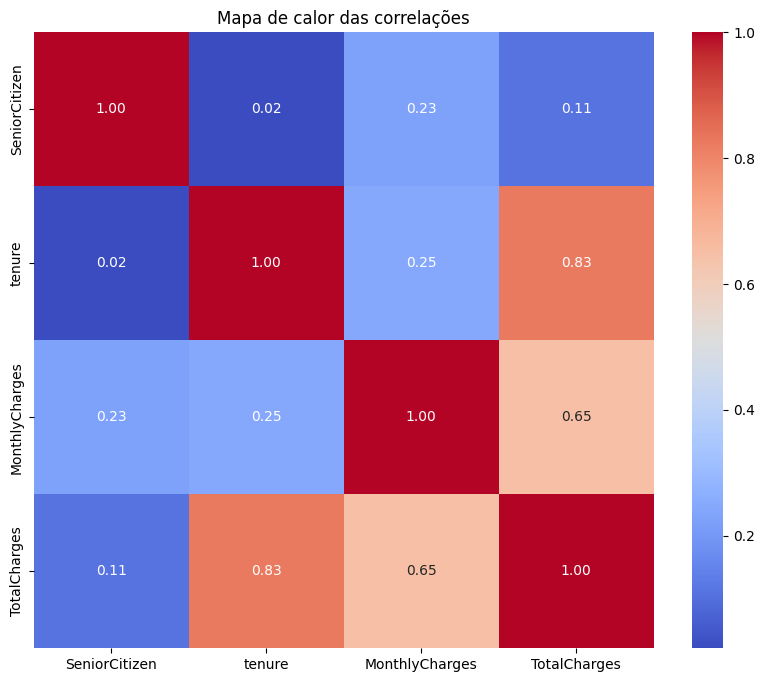

In [18]:
numericdfTrainFoldOne = dfTrainFoldOne.select_dtypes(include=["number"])

correlation_matrix = numericdfTrainFoldOne.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor das correlações")
plt.show()

In [19]:
dfTrainFoldOne.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6653,Female,0,No,No,28,No,No phone service,DSL,No,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,29.75,790.7,No
6116,Female,0,No,No,48,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,One year,Yes,Bank transfer (automatic),73.85,3581.4,No
4896,Male,0,No,No,24,Yes,No,DSL,No,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,49.70,1167.8,No
2732,Female,0,No,Yes,4,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.40,94.5,No
4233,Female,0,Yes,No,33,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),59.55,2016.3,No


<Axes: xlabel='Churn', ylabel='count'>

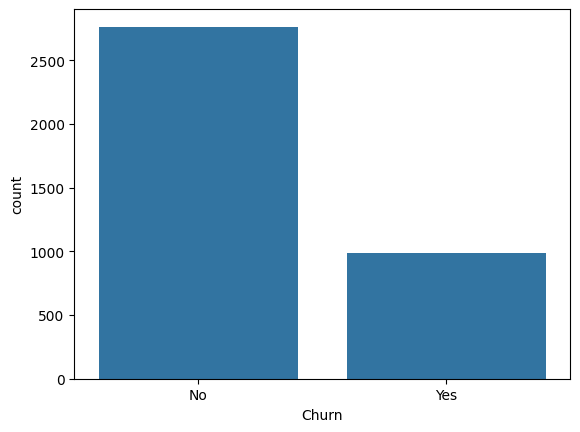

In [20]:
sns.countplot(x='Churn', data=dfTrainFoldOne)

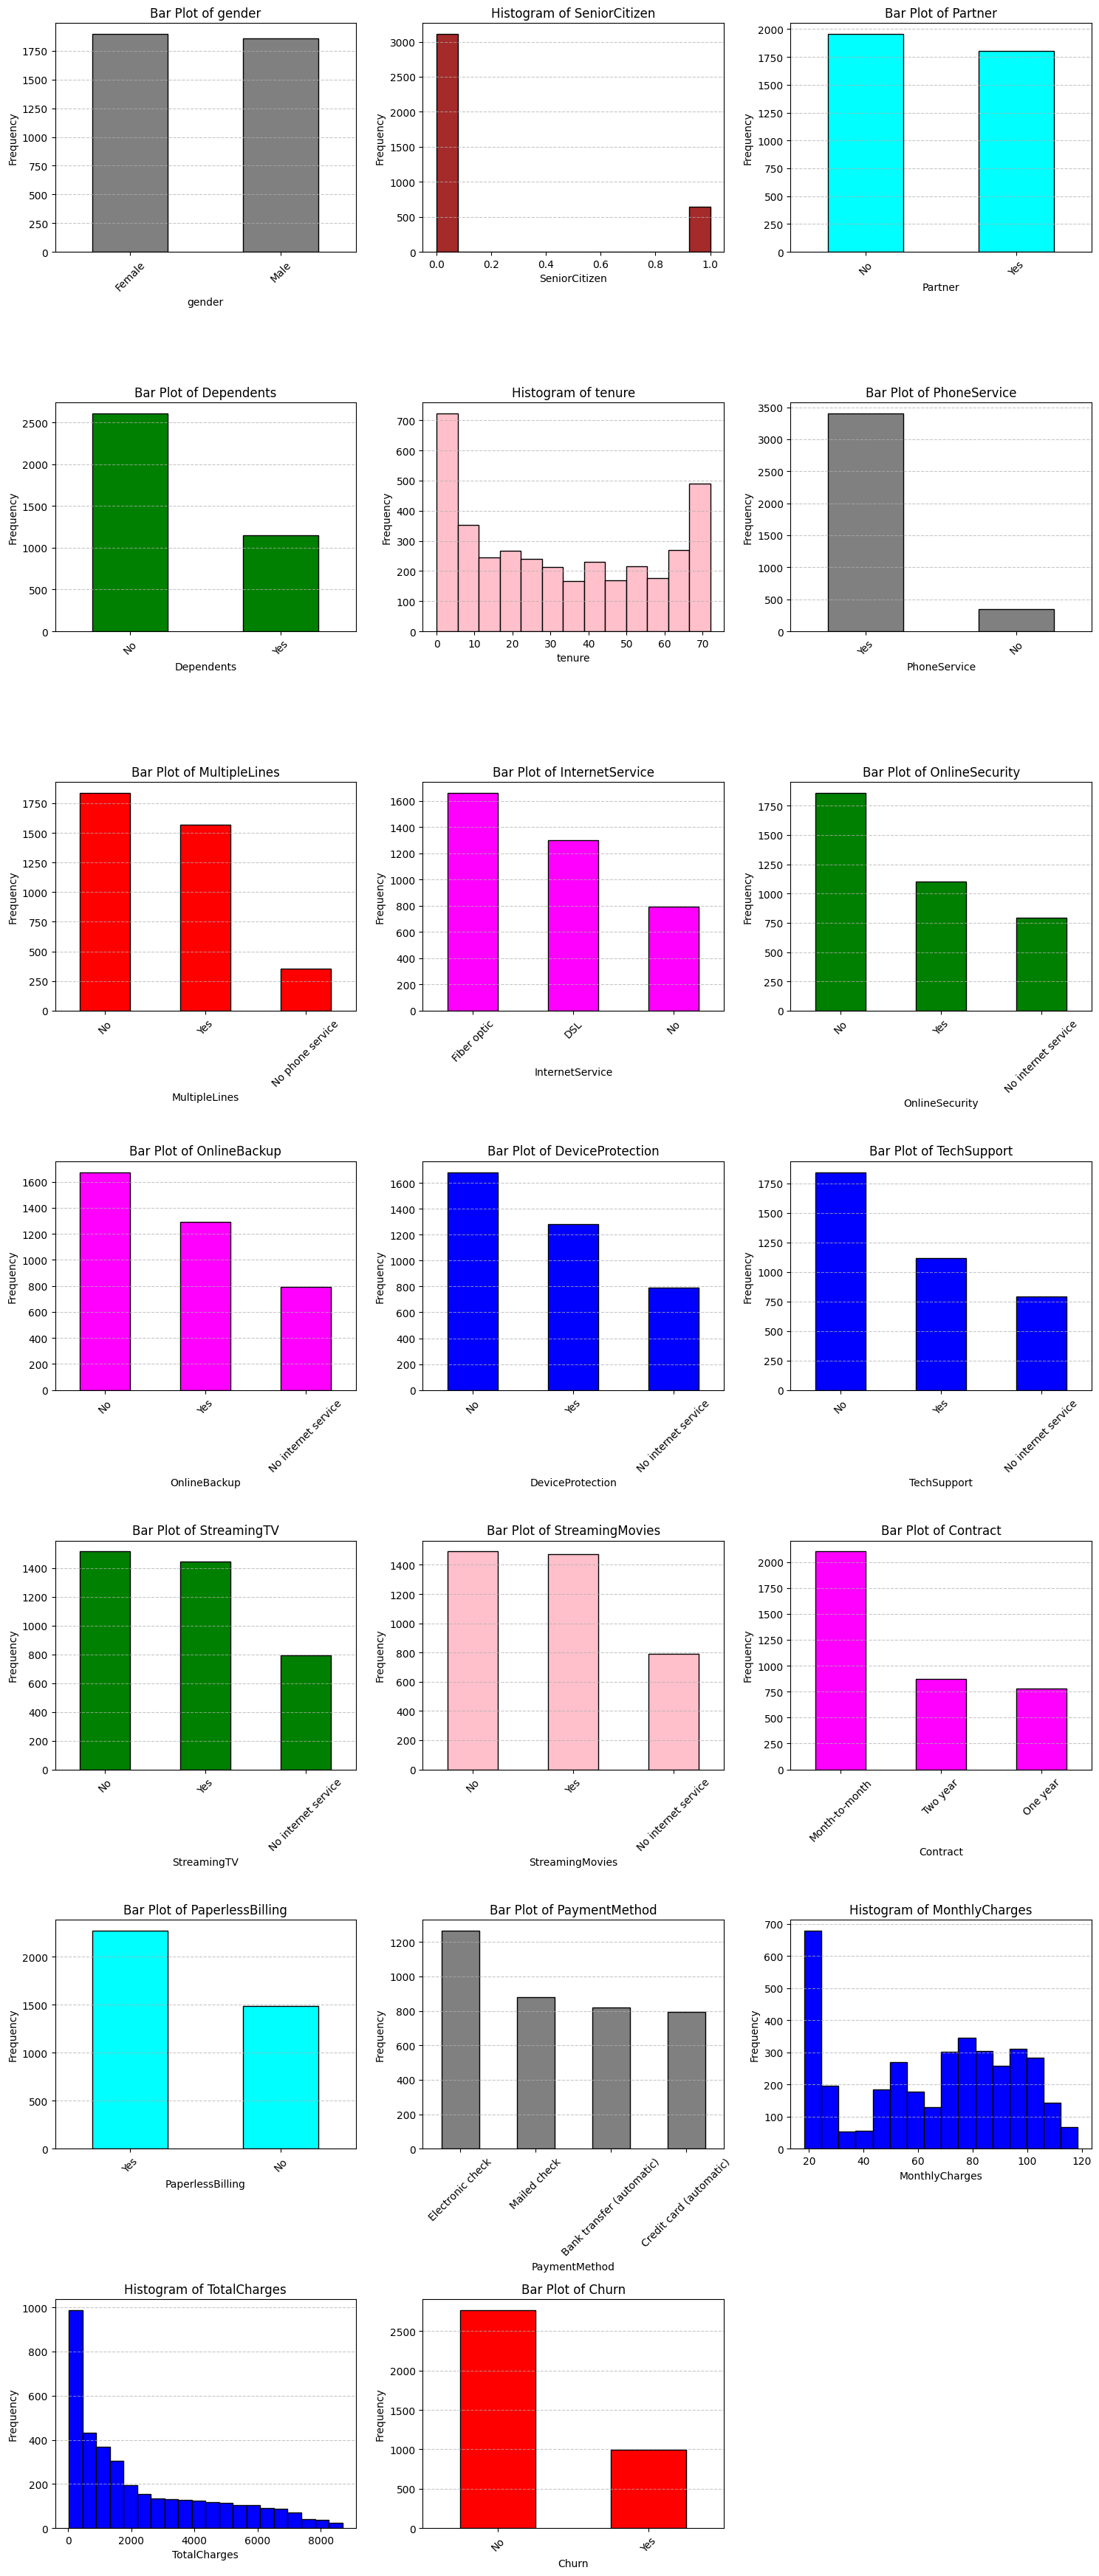

In [21]:
plotHistogram(dfTrainFoldOne)

Como podemos observar, as variáveis númericas 'tenure', 'MonthlyCharges' e 'TotallyCharges' possuem um grande variação de valores e, por isso trazem a necessidade colocar em faixas, como mostrado abaixo:

In [22]:
maxTenure, maxMonthlyCharges, maxTotallyCharges = dfTrainFoldOne['tenure'].max(), dfTrainFoldOne['MonthlyCharges'].max(), dfTrainFoldOne['TotalCharges'].max()
print(maxTenure)
print(maxMonthlyCharges)
print(maxTotallyCharges)


72
118.6
8684.8


# 4. Tratamento dos Dados

## 4.1 Tratamento de Dados Nulos

In [23]:
dfTrainFoldOne.isnull().sum() / len(dfTrainFoldOne) * 100

gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.079872
Churn               0.000000
dtype: float64

### *Median Imputation*

Como aproximadamente `16%` da coluna `TotalCharges` não possui valores, optamos por utilizar a *median imputation* para preencher os valores.

In [24]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = fix_missing_values_median(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "TotalCharges")

/tmp/ipykernel_8984/332783124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df_copy[column].fillna(median_value, inplace=True)
/tmp/ipykernel_8984/332783124.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [25]:
dfTrainFoldOne.isnull().sum() / len(dfTrainFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [26]:
dfTestFoldOne.isnull().sum() / len(dfTestFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [27]:
dfValFoldOne.isnull().sum() / len(dfValFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

## 4.2 Tratamento de Outliers

/tmp/ipykernel_8984/2271309273.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(numeric_columns, rotation=45, ha='right', fontsize=12)


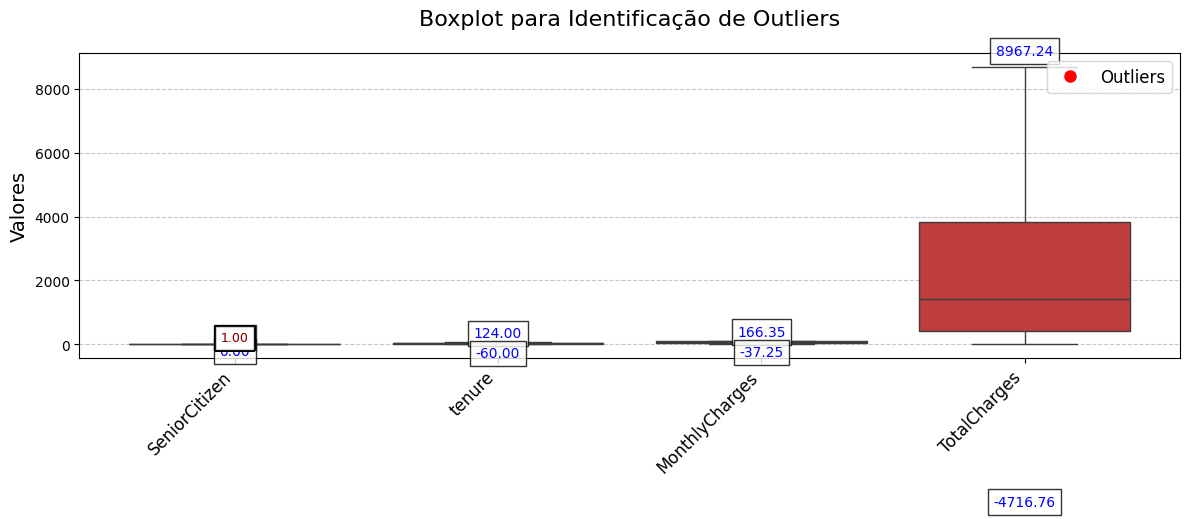

In [28]:
plot_outliers(dfTrainFoldOne)

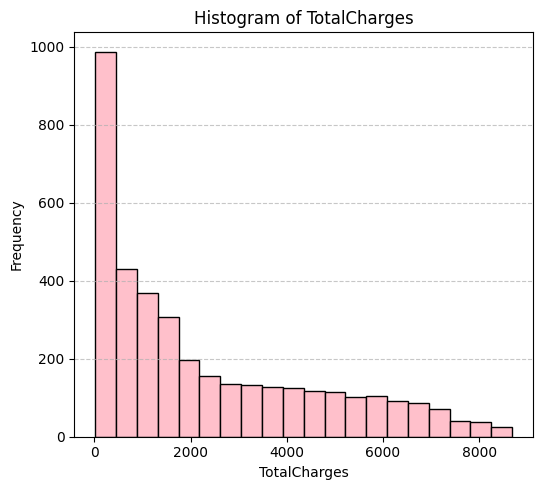

In [29]:
plotHistogram(dfTrainFoldOne['TotalCharges'])

In [30]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = remove_outliers(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "TotalCharges")

In [31]:
dfTrainFoldOne["tenure"].isnull().sum()

0

In [32]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = bin_columns(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "tenure")

In [33]:
dfTrainFoldOne["tenure"].isnull().sum()

0

## 4.3 Normalização de dados numéricos com Min-Max

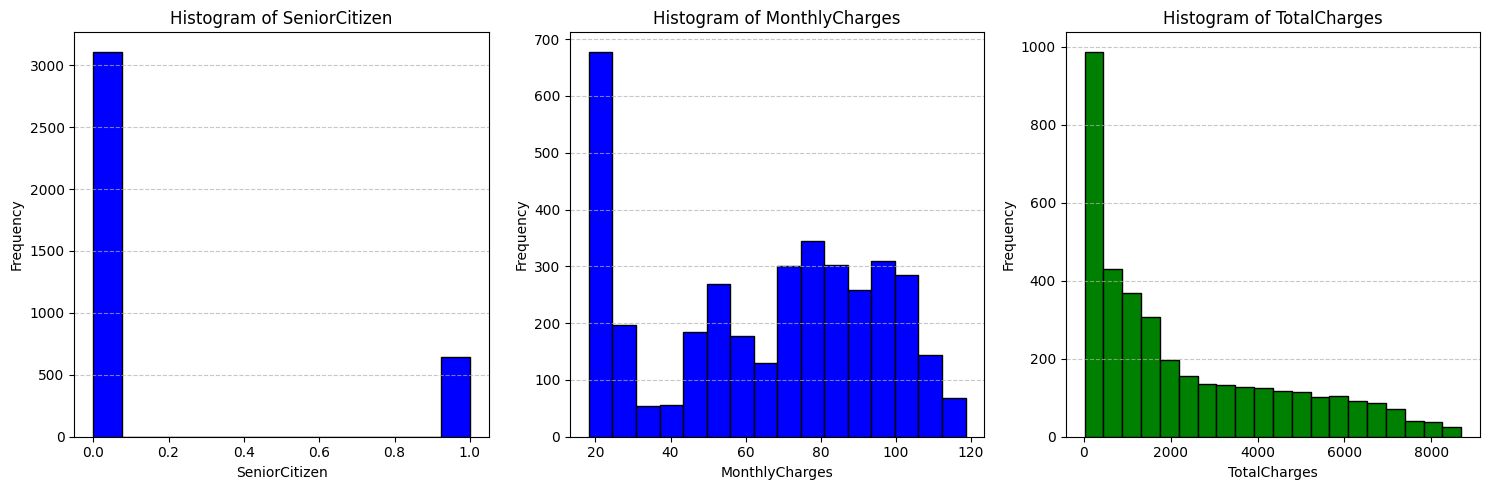

In [34]:
numeric_cols = dfTrainFoldOne.select_dtypes(include=['number'])
plotHistogram(numeric_cols)

In [35]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = normalize_data(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy())

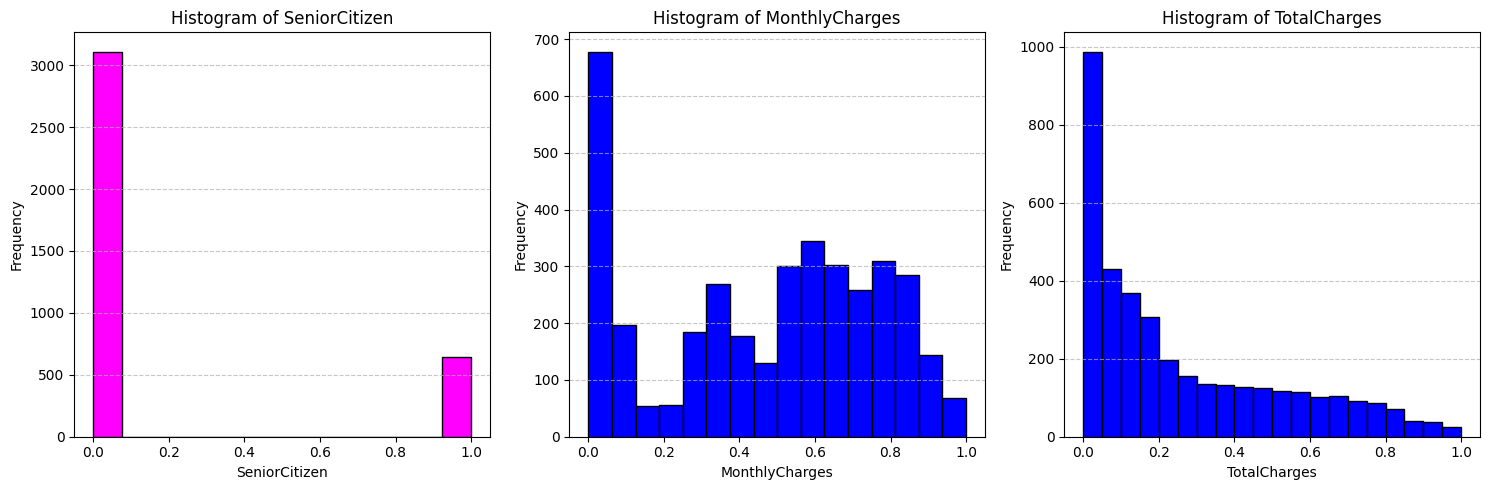

In [36]:
plotHistogram(dfTrainFoldOne[numeric_cols.columns])

## 4.4 Tratamento de Variáveis Categóricas

A seguir, transformamos as variáveis categóricas em numéricas. Para as colunas binárias, mapeamos os valores "Yes" e "No" para 1 e 0, respectivamente. Em seguida, aplicamos **One-Hot Encoding** a todas as variáveis categóricas(não necessário utilizar a codificação de bits, pois o máximo de valores únicos em uma categoria é 4), **exceto "Contract"**, pois ela possui um aspecto ordinal e deve ser codificada de forma diferente.  

Além disso, a variável numérica **"tenure"** é convertida em faixas, representando diferentes períodos de tempo, e depois transformada em valores numéricos ordinais.  

Essas transformações são realizadas nas funções **`preprocess_categorical_data`** (para variáveis categóricas) e **`bin_and_encode`** (para a variável "tenure").

In [37]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = preprocess_categorical_data(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy())

In [38]:
dfTrainFoldOne.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes
6653,0.0,0,0,1.0,0,0.0,1,0.114599,0.089067,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6116,0.0,0,0,2.0,1,1.0,1,0.554061,0.411097,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4896,0.0,0,0,1.0,1,0.0,1,0.313403,0.132582,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2732,0.0,0,1,0.0,1,0.0,0,0.021425,0.008730,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4233,0.0,1,0,1.0,0,2.0,0,0.411560,0.230494,0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## 4.4 Tratamentos nos *folds* `k=2` e `k=3`

### `k=2`

In [39]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = fix_missing_values_median(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "TotalCharges")

/tmp/ipykernel_8984/332783124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df_copy[column].fillna(median_value, inplace=True)
/tmp/ipykernel_8984/332783124.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [40]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = remove_outliers(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "TotalCharges")

In [41]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = normalize_data(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())

In [42]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = bin_columns(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "tenure")
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = preprocess_categorical_data(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())

### `k=3`

In [43]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = fix_missing_values_median(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "TotalCharges")

/tmp/ipykernel_8984/332783124.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df_copy[column].fillna(median_value, inplace=True)
/tmp/ipykernel_8984/332783124.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [44]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = remove_outliers(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "TotalCharges")

In [45]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = normalize_data(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())

In [46]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = bin_columns(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "tenure")
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = preprocess_categorical_data(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())

# 5. Experimentos

## *Random Forest*

### Parâmetros que serão variados
- Número de árvores (`n_estimators`)
- Profundidade máxima (`max_depth`)
- Número mínimo de amostras para dividir um nó (`min_samples_split`)
- Critério de divisão (`criterion`)

In [91]:
#Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]
#Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
X_val_fold_two = dfValFoldTwo.drop("Churn", axis=1)
y_val_fold_two = dfValFoldTwo["Churn"]
#Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]
X_val_fold_three = dfValFoldThree.drop("Churn", axis=1)
y_val_fold_three = dfValFoldThree["Churn"]

### Otimização com Optuna

In [92]:
def objective_RF(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_fold_one, y_train_fold_one)
    y_proba = model.predict_proba(X_val_fold_one)[:, 1]
    ks_value, _ = ks_2samp(y_proba[y_val_fold_one == 1], y_proba[y_val_fold_one == 0])
    return ks_value

In [93]:
study_RF = optuna.create_study(direction="maximize")  
study_RF.optimize(objective_RF, n_trials=50)  

[I 2025-04-14 12:32:07,624] A new study created in memory with name: no-name-d684303f-a6dd-4938-a2f4-350a07d2a23b
[I 2025-04-14 12:32:08,709] Trial 0 finished with value: 0.5424116645381013 and parameters: {'n_estimators': 212, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5424116645381013.
[I 2025-04-14 12:32:09,896] Trial 1 finished with value: 0.5337909748829289 and parameters: {'n_estimators': 292, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.5424116645381013.
[I 2025-04-14 12:32:10,188] Trial 2 finished with value: 0.5367354902795516 and parameters: {'n_estimators': 107, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.5424116645381013.
[I 2025-04-14 12:32:10,920] Trial 3 finished with value: 0.5371257272598269 and parameters: {'n_estimators': 182, 'max_depth': 7, 'min_samp

In [94]:
print("Melhores hiperparâmetros:", study_RF.best_params)

Melhores hiperparâmetros: {'n_estimators': 236, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}


### Treinamento do Modelo

#### Fold One

In [95]:
print("Random Forest Fold One: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_one, y_train_fold_one)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_one)
accuracy_RF = accuracy_score(y_val_fold_one, y_pred)
f1_value_RF = f1_score(y_val_fold_one, y_pred)
y_probs = final_model.predict_proba(X_val_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_one == 1], y_probs[y_val_fold_one == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_one)
accuracy_RF = accuracy_score(y_test_fold_one, y_pred)
f1_value_RF = f1_score(y_test_fold_one, y_pred)
y_probs = final_model.predict_proba(X_test_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_one == 1], y_probs[y_test_fold_one == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

Random Forest Fold One: 

Acurácia final no conjunto de validação: 79.45%
F1-Score final no conjunto de validação: 55.43%
KS no conjunto de validação: 53.5423%


Acurácia final no conjunto de teste: 80.83%
F1-Score final no conjunto de teste: 59.82%
KS no conjunto de teste: 55.8659%


##### ROC-AUC Fold One

ROC-AUC Fold One: 85.3180%


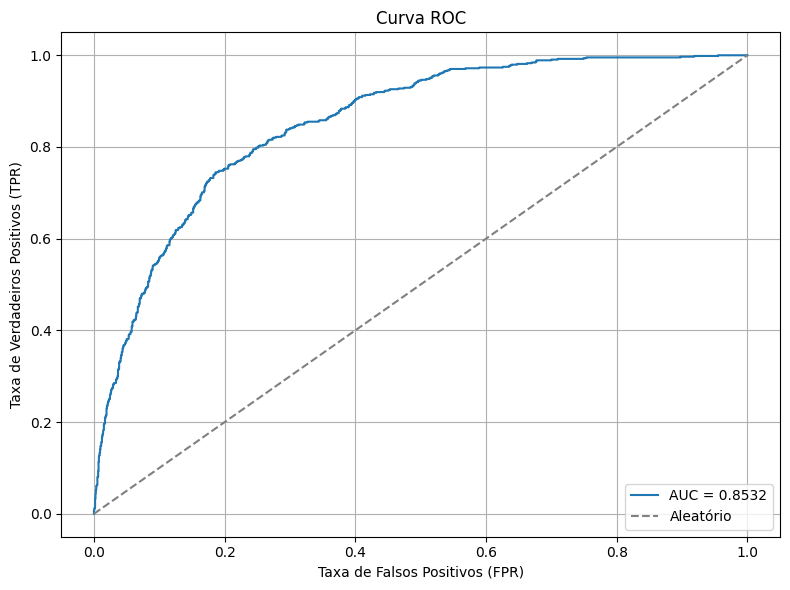

In [98]:
y_probs = final_model.predict_proba(X_test_fold_one)[:, 1]
roc_auc = roc_auc_score(y_test_fold_one, y_probs)
print(f"ROC-AUC Fold One: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_fold_one, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Fold Two

In [99]:
print("Random Forest Fold Two: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_two, y_train_fold_two)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_two)
accuracy_RF = accuracy_score(y_val_fold_two, y_pred)
f1_value_RF = f1_score(y_val_fold_two, y_pred)
y_probs = final_model.predict_proba(X_val_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_two == 1], y_probs[y_val_fold_two == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_two)
accuracy_RF = accuracy_score(y_test_fold_two, y_pred)
f1_value_RF = f1_score(y_test_fold_two, y_pred)
y_probs = final_model.predict_proba(X_test_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_two == 1], y_probs[y_test_fold_two == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

Random Forest Fold Two: 

Acurácia final no conjunto de validação: 79.66%
F1-Score final no conjunto de validação: 55.48%
KS no conjunto de validação: 52.6062%


Acurácia final no conjunto de teste: 79.94%
F1-Score final no conjunto de teste: 55.52%
KS no conjunto de teste: 51.4995%


##### ROC-AUC Fold Two

ROC-AUC Fold Two: 83.7283%


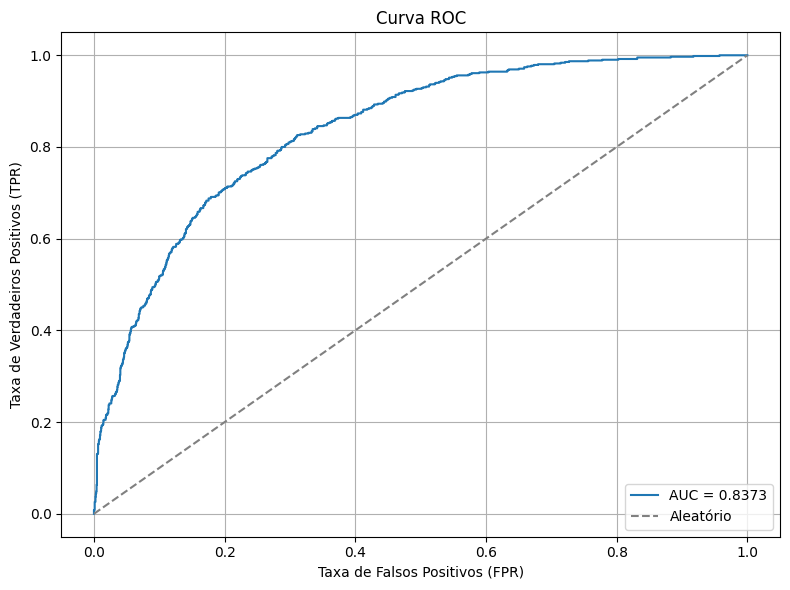

In [100]:
y_probs = final_model.predict_proba(X_test_fold_two)[:, 1]
roc_auc = roc_auc_score(y_test_fold_two, y_probs)
print(f"ROC-AUC Fold Two: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_fold_two, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Fold Three

In [101]:
print("Random Forest Fold Three: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_three, y_train_fold_three)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_three)
accuracy_RF = accuracy_score(y_val_fold_three, y_pred)
f1_value_RF = f1_score(y_val_fold_three, y_pred)
y_probs = final_model.predict_proba(X_val_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_three == 1], y_probs[y_val_fold_three == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_three)
accuracy_RF = accuracy_score(y_test_fold_three, y_pred)
f1_value_RF = f1_score(y_test_fold_three, y_pred)
y_probs = final_model.predict_proba(X_test_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_three == 1], y_probs[y_test_fold_three == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

Random Forest Fold Three: 

Acurácia final no conjunto de validação: 78.83%
F1-Score final no conjunto de validação: 55.28%
KS no conjunto de validação: 53.5958%


Acurácia final no conjunto de teste: 79.80%
F1-Score final no conjunto de teste: 55.28%
KS no conjunto de teste: 52.2382%


##### ROC-AUC Fold Three

ROC-AUC Fold Three: 83.4818%


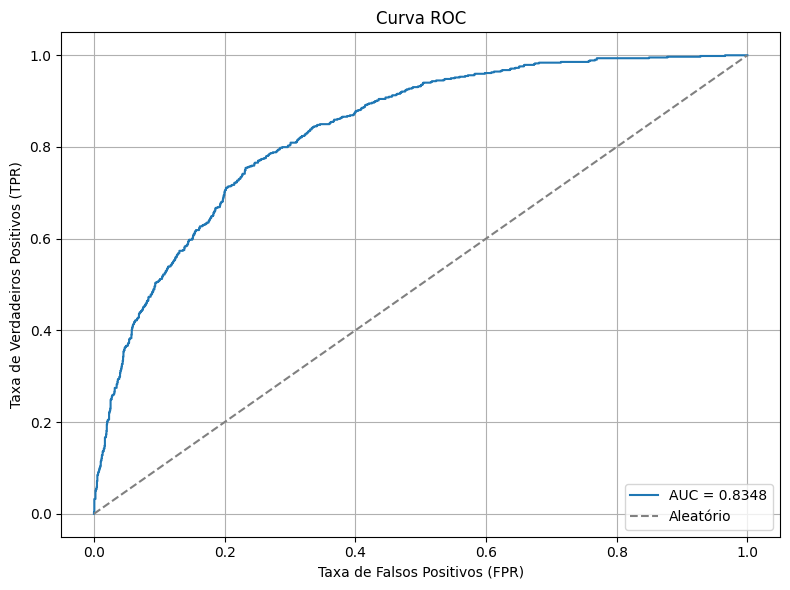

In [102]:
y_probs = final_model.predict_proba(X_test_fold_three)[:, 1]
roc_auc = roc_auc_score(y_test_fold_three, y_probs)
print(f"ROC-AUC Fold Three: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_fold_three, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## MLP

### Parâmetros que serão variados

- Número de camadas
- Número de neurônios
- Taxa de aprendizagem
- Otimização

In [103]:
print("CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Versão do PyTorch:", torch.__version__)

CUDA disponível: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Versão do PyTorch: 2.3.0+cu121


### Otimização com Optuna

In [104]:
def objective_MLP_Cuda(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    n_neurons = trial.suggest_int("n_neurons", 10, 200)
    activation_name = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    learning_rate = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    input_size = X_train_fold_one.shape[1]
    output_size = len(np.unique(y_train_fold_one))

    layers = [nn.Linear(input_size, n_neurons)]
    if activation_name == "relu":
        layers.append(nn.ReLU())
    elif activation_name == "tanh":
        layers.append(nn.Tanh())
    elif activation_name == "logistic":
        layers.append(nn.Sigmoid())
    layers.append(nn.Linear(n_neurons, output_size))

    model = nn.Sequential(*layers).to(device)

    X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        y_probs = probabilities[:, 1].cpu().numpy()  # Assumes class 1 is the positive class
        y_true = y_test_tensor.cpu().numpy()

    # Compute KS statistic between positive and negative classes
    ks_statistic, _ = ks_2samp(y_probs[y_true == 1], y_probs[y_true == 0])
    return ks_statistic

In [105]:
study_MLP = optuna.create_study(direction="maximize")
study_MLP.optimize(objective_MLP_Cuda, n_trials=50)

print("Melhores hiperparâmetros:", study_MLP.best_params)

[I 2025-04-14 12:33:45,203] A new study created in memory with name: no-name-d7594e72-5c1f-4c48-8891-38becfbd8cf1
[I 2025-04-14 12:33:45,602] Trial 0 finished with value: 0.5463721150442885 and parameters: {'n_neurons': 190, 'activation': 'relu', 'learning_rate_init': 0.0013966167260914205}. Best is trial 0 with value: 0.5463721150442885.
[I 2025-04-14 12:33:45,824] Trial 1 finished with value: 0.5458701637776889 and parameters: {'n_neurons': 39, 'activation': 'tanh', 'learning_rate_init': 0.0008334614016613449}. Best is trial 0 with value: 0.5463721150442885.
[I 2025-04-14 12:33:45,948] Trial 2 finished with value: 0.5269440269178262 and parameters: {'n_neurons': 36, 'activation': 'relu', 'learning_rate_init': 0.0004574174750380219}. Best is trial 0 with value: 0.5463721150442885.
[I 2025-04-14 12:33:46,078] Trial 3 finished with value: 0.5319405564672192 and parameters: {'n_neurons': 118, 'activation': 'logistic', 'learning_rate_init': 0.0007456910976381523}. Best is trial 0 with val

Melhores hiperparâmetros: {'n_neurons': 176, 'activation': 'relu', 'learning_rate_init': 0.0015001812132814261}


### Treinamento do Modelo

#### Fold One

In [106]:
print("MLP Fold One: \n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_one.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_one.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()  
    y_pred = torch.argmax(outputs, dim=1)
    
y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic*100))

MLP Fold One: 

Epoch 1, Train Loss: 0.6723, Val Loss: 0.6368, Val Acc: 0.7295
Epoch 2, Train Loss: 0.6364, Val Loss: 0.6064, Val Acc: 0.7412
Epoch 3, Train Loss: 0.6072, Val Loss: 0.5819, Val Acc: 0.7412
Epoch 4, Train Loss: 0.5838, Val Loss: 0.5621, Val Acc: 0.7412
Epoch 5, Train Loss: 0.5651, Val Loss: 0.5461, Val Acc: 0.7412
Epoch 6, Train Loss: 0.5502, Val Loss: 0.5330, Val Acc: 0.7412
Epoch 7, Train Loss: 0.5378, Val Loss: 0.5219, Val Acc: 0.7412
Epoch 8, Train Loss: 0.5272, Val Loss: 0.5120, Val Acc: 0.7412
Epoch 9, Train Loss: 0.5177, Val Loss: 0.5028, Val Acc: 0.7412
Epoch 10, Train Loss: 0.5087, Val Loss: 0.4941, Val Acc: 0.7412
Epoch 11, Train Loss: 0.4998, Val Loss: 0.4857, Val Acc: 0.7412
Epoch 12, Train Loss: 0.4912, Val Loss: 0.4777, Val Acc: 0.7412
Epoch 13, Train Loss: 0.4826, Val Loss: 0.4701, Val Acc: 0.7412
Epoch 14, Train Loss: 0.4745, Val Loss: 0.4633, Val Acc: 0.7444
Epoch 15, Train Loss: 0.4668, Val Loss: 0.4573, Val Acc: 0.7678
Epoch 16, Train Loss: 0.4600, Val

##### ROC-AUC Fold One

ROC-AUC Fold One: 85.2181%


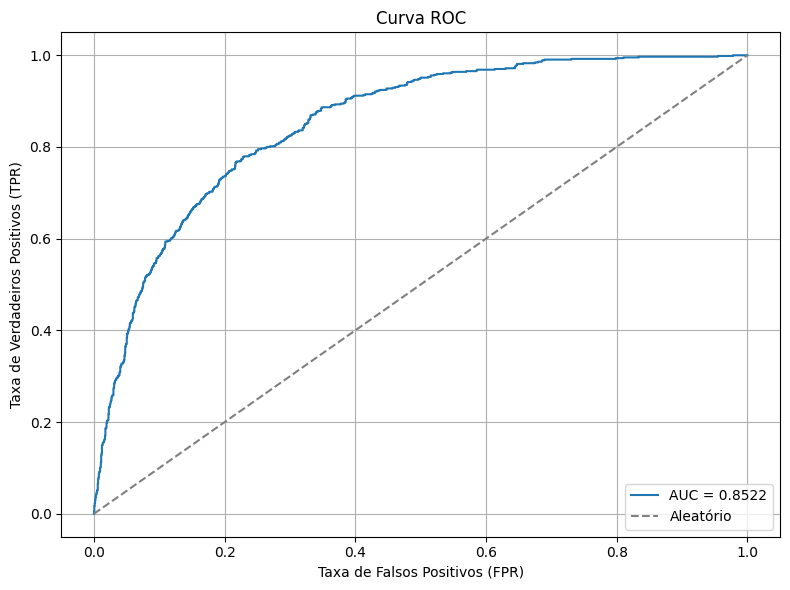

In [107]:
y_probs = probabilities[:, 1].cpu().numpy()
roc_auc = roc_auc_score(y_test_cpu, y_probs)
print(f"ROC-AUC Fold One: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_cpu, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Fold Two

In [108]:
print("MLP Fold Two: \n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_two.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_two.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_two.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_two.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()
    y_pred = torch.argmax(outputs, dim=1)

y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

MLP Fold Two: 

Epoch 1, Train Loss: 0.6791, Val Loss: 0.6463, Val Acc: 0.7061
Epoch 2, Train Loss: 0.6410, Val Loss: 0.6176, Val Acc: 0.7242
Epoch 3, Train Loss: 0.6106, Val Loss: 0.5954, Val Acc: 0.7242
Epoch 4, Train Loss: 0.5870, Val Loss: 0.5784, Val Acc: 0.7242
Epoch 5, Train Loss: 0.5687, Val Loss: 0.5653, Val Acc: 0.7242
Epoch 6, Train Loss: 0.5543, Val Loss: 0.5548, Val Acc: 0.7242
Epoch 7, Train Loss: 0.5428, Val Loss: 0.5460, Val Acc: 0.7242
Epoch 8, Train Loss: 0.5330, Val Loss: 0.5380, Val Acc: 0.7242
Epoch 9, Train Loss: 0.5243, Val Loss: 0.5304, Val Acc: 0.7242
Epoch 10, Train Loss: 0.5160, Val Loss: 0.5229, Val Acc: 0.7242
Epoch 11, Train Loss: 0.5079, Val Loss: 0.5153, Val Acc: 0.7242
Epoch 12, Train Loss: 0.5000, Val Loss: 0.5077, Val Acc: 0.7242
Epoch 13, Train Loss: 0.4922, Val Loss: 0.5003, Val Acc: 0.7242
Epoch 14, Train Loss: 0.4847, Val Loss: 0.4932, Val Acc: 0.7274
Epoch 15, Train Loss: 0.4776, Val Loss: 0.4866, Val Acc: 0.7274
Epoch 16, Train Loss: 0.4712, Val

##### ROC-AUC Fold Two

ROC-AUC Fold Two: 83.3243%


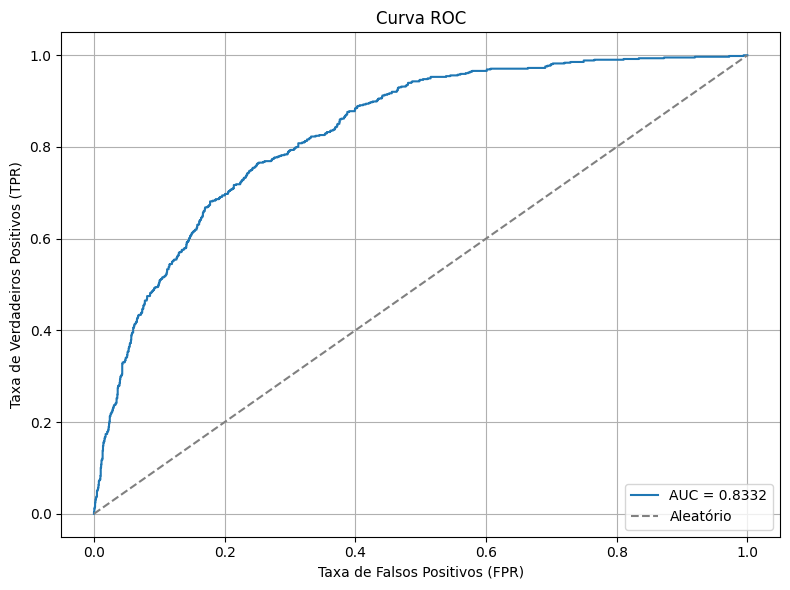

In [109]:
y_probs = probabilities[:, 1].cpu().numpy()
roc_auc = roc_auc_score(y_test_cpu, y_probs)
print(f"ROC-AUC Fold Two: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_cpu, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Fold Three

In [110]:
print("MLP Fold Three: \n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_three.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_three.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_three.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_two.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()
    y_pred = torch.argmax(outputs, dim=1)

y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

MLP Fold Three: 

Epoch 1, Train Loss: 0.6719, Val Loss: 0.6450, Val Acc: 0.7223
Epoch 2, Train Loss: 0.6406, Val Loss: 0.6214, Val Acc: 0.7223
Epoch 3, Train Loss: 0.6148, Val Loss: 0.6021, Val Acc: 0.7223
Epoch 4, Train Loss: 0.5934, Val Loss: 0.5863, Val Acc: 0.7223
Epoch 5, Train Loss: 0.5756, Val Loss: 0.5731, Val Acc: 0.7223
Epoch 6, Train Loss: 0.5605, Val Loss: 0.5619, Val Acc: 0.7223
Epoch 7, Train Loss: 0.5476, Val Loss: 0.5520, Val Acc: 0.7223
Epoch 8, Train Loss: 0.5360, Val Loss: 0.5428, Val Acc: 0.7223
Epoch 9, Train Loss: 0.5254, Val Loss: 0.5339, Val Acc: 0.7223
Epoch 10, Train Loss: 0.5153, Val Loss: 0.5252, Val Acc: 0.7223
Epoch 11, Train Loss: 0.5056, Val Loss: 0.5165, Val Acc: 0.7223
Epoch 12, Train Loss: 0.4960, Val Loss: 0.5079, Val Acc: 0.7223
Epoch 13, Train Loss: 0.4867, Val Loss: 0.4995, Val Acc: 0.7223
Epoch 14, Train Loss: 0.4778, Val Loss: 0.4914, Val Acc: 0.7245
Epoch 15, Train Loss: 0.4695, Val Loss: 0.4839, Val Acc: 0.7383
Epoch 16, Train Loss: 0.4620, V

##### ROC-AUC Fold Three

ROC-AUC Fold Three: 82.7670%


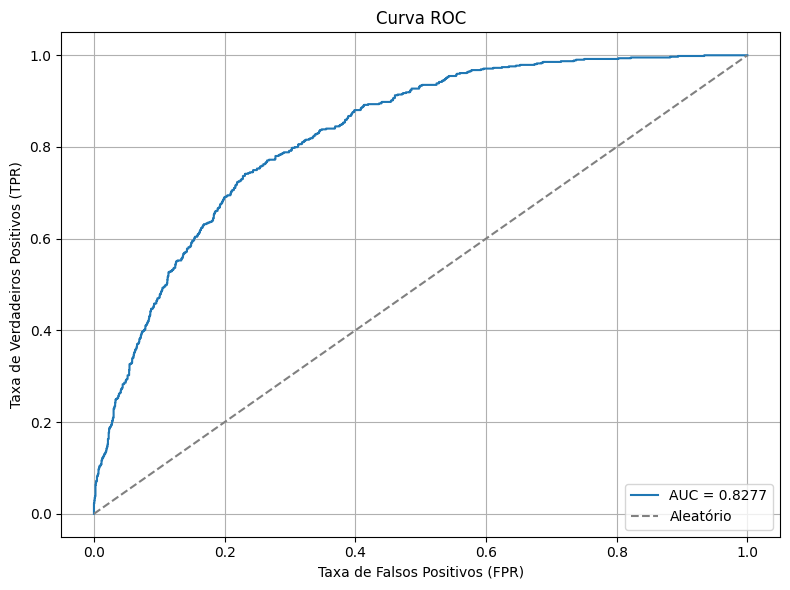

In [111]:
y_probs = probabilities[:, 1].cpu().numpy()
roc_auc = roc_auc_score(y_test_cpu, y_probs)
print(f"ROC-AUC Fold Three: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_cpu, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## *Gradient Boosting*

### Parâmetros que serão variados
- Número de estimadores
- Taxa de aprendizagem
- Profundidade Máxima
- Mínimo de amostras para divisão
- Mínimo de amostras na folha
- Fração de amostras

In [112]:
#Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
#Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
#Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]

### Otimização com Optuna

In [113]:
def objective_GB(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )

    model.fit(X_train_fold_one, y_train_fold_one)
    y_proba = model.predict_proba(X_val_fold_one)[:, 1]
    ks_value, _ = ks_2samp(y_proba[y_val_fold_one == 1], y_proba[y_val_fold_one == 0])
    return ks_value

In [114]:
study_GB = optuna.create_study(direction="maximize")
study_GB.optimize(objective_GB, n_trials=50)

[I 2025-04-14 12:34:15,084] A new study created in memory with name: no-name-34907d5c-fd62-4e5d-befd-7310371c446b
[I 2025-04-14 12:34:16,592] Trial 0 finished with value: 0.4836809990066695 and parameters: {'n_estimators': 159, 'learning_rate': 0.05713665994521671, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 10, 'subsample': 0.5414771736805857}. Best is trial 0 with value: 0.4836809990066695.
[I 2025-04-14 12:34:17,509] Trial 1 finished with value: 0.5223676741875976 and parameters: {'n_estimators': 270, 'learning_rate': 0.023287074665055463, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.8945236087721147}. Best is trial 1 with value: 0.5223676741875976.
[I 2025-04-14 12:34:19,307] Trial 2 finished with value: 0.46324677167589046 and parameters: {'n_estimators': 257, 'learning_rate': 0.12855258989567683, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.8243058567672683}. Best is trial 1 with value: 0.522367674

### Treinamento do Modelo

#### Fold One

In [115]:
print("Gradient Boosting Fold One: \n")
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_one, y_train_fold_one)

y_pred = final_model.predict(X_test_fold_one)
accuracy_GB = accuracy_score(y_test_fold_one, y_pred)
f1_value_GB = f1_score(y_test_fold_one, y_pred)
y_probs = final_model.predict_proba(X_test_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_one == 1], y_probs[y_test_fold_one == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Gradient Boosting Fold One: 

Acurácia final: 80.20%
F1-Score final: 58.74%
KS: 53.6298%


##### ROC-AUC Fold One

ROC-AUC Fold One: 84.4789%


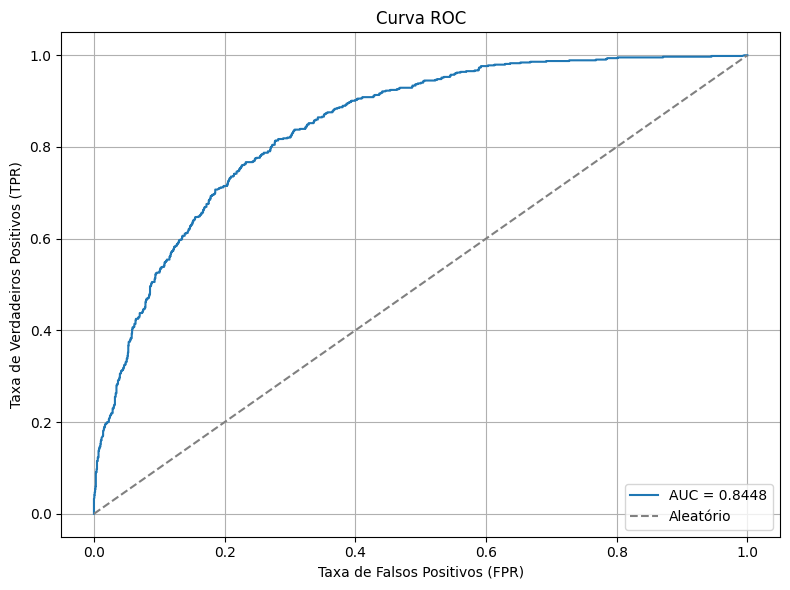

In [116]:
y_probs = final_model.predict_proba(X_test_fold_one)[:, 1]
roc_auc = roc_auc_score(y_test_fold_one, y_probs)
print(f"ROC-AUC Fold One: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_fold_one, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Fold Two

In [117]:
print("Gradient Boosting Fold Two: \n")
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_two, y_train_fold_two)

y_pred = final_model.predict(X_test_fold_two)
accuracy_GB = accuracy_score(y_test_fold_two, y_pred)
f1_value_GB = f1_score(y_test_fold_two, y_pred)
y_probs = final_model.predict_proba(X_test_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_two == 1], y_probs[y_test_fold_two == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Gradient Boosting Fold Two: 

Acurácia final: 79.60%
F1-Score final: 56.57%
KS: 49.4810%


##### ROC-AUC Fold Two

ROC-AUC Fold Two: 83.0593%


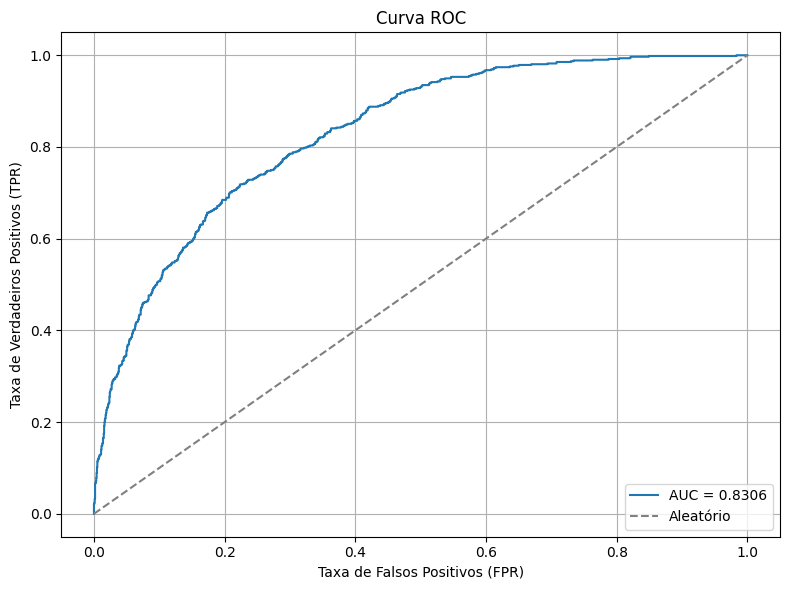

In [118]:
y_probs = final_model.predict_proba(X_test_fold_two)[:, 1]
roc_auc = roc_auc_score(y_test_fold_two, y_probs)
print(f"ROC-AUC Fold Two: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_fold_two, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Fold Three

In [119]:
print("Gradient Boosting Fold Three: \n")
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_three, y_train_fold_three)

y_pred = final_model.predict(X_test_fold_three)
accuracy_GB = accuracy_score(y_test_fold_three, y_pred)
f1_value_GB = f1_score(y_test_fold_three, y_pred)
y_probs = final_model.predict_proba(X_test_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_three == 1], y_probs[y_test_fold_three == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Gradient Boosting Fold Three: 

Acurácia final: 79.72%
F1-Score final: 57.19%
KS: 49.2482%


##### ROC-AUC Fold Three

ROC-AUC Fold Three: 82.3904%


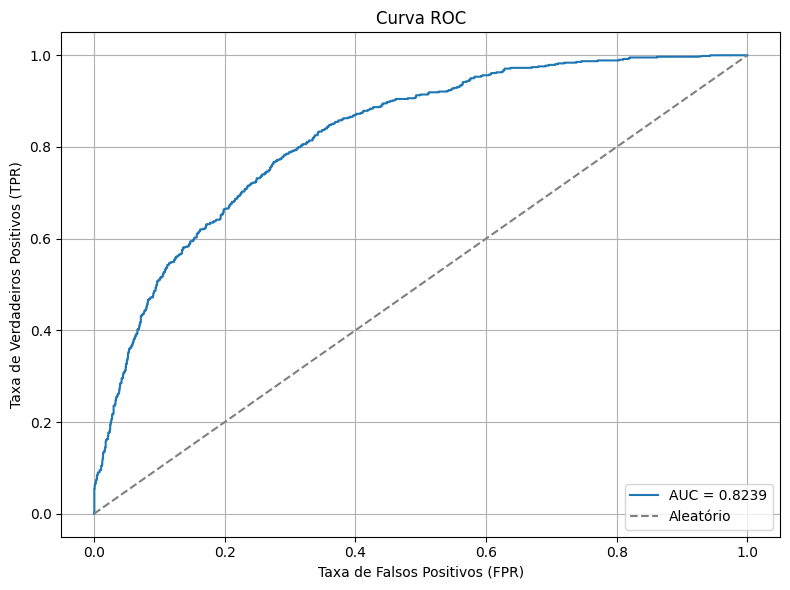

In [120]:
y_probs = final_model.predict_proba(X_test_fold_three)[:, 1]
roc_auc = roc_auc_score(y_test_fold_three, y_probs)
print(f"ROC-AUC Fold Three: {roc_auc * 100:.4f}%")

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test_fold_three, y_probs)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## KAN

### Parâmetros que serão variados

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from scipy.stats import ks_2samp
from kan import KAN 
import gc 

In [48]:
# Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]

# Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
X_val_fold_two = dfValFoldTwo.drop("Churn", axis=1) 
y_val_fold_two = dfValFoldTwo["Churn"]  

# Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]
X_val_fold_three = dfValFoldThree.drop("Churn", axis=1) 
y_val_fold_three = dfValFoldThree["Churn"] 

### Otimização com Optuna

In [49]:
def objective_KAN_Cuda_KS(trial):                                     
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    hidden_neurons = trial.suggest_int("hidden_neurons", 5, 50, step=5)
    grid_size = trial.suggest_int("grid_size", 3, 10)
    spline_order = trial.suggest_int("spline_order", 1, 4) 
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)

    X_train_np = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
    y_train_np = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
    X_test_np = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
    y_test_np = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one

    input_size = X_train_np.shape[1]
    unique_labels = np.unique(y_train_np)
    output_size = len(unique_labels)

    is_binary = False
    if output_size == 1:
         print(f"Warning: Trial {trial.number}: Only 1 class found. KS score undefined.")
         return 0.0 
    elif output_size == 2:
        print(f"Trial {trial.number}: Binary classification (Classes: {unique_labels}). Output size = 2.")
        is_binary = True 
    else:
        print(f"Trial {trial.number}: Multi-class classification (Classes: {unique_labels}). KS not applicable.")
        return 0.0 

    width = [input_size, hidden_neurons, output_size]
    model = None
    try:
        model = KAN(width=width, grid=grid_size, k=spline_order, device=device)
    except Exception as e:
        print(f"Error creating KAN model in trial {trial.number}: {e}")
        del model; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return 0.0

    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
    y_test_cpu_np = y_test_np # Keep test labels as numpy array on CPU

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 50 

    try:
        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            if outputs.shape[0] != y_train_tensor.shape[0]:
                 raise ValueError("Output and target shape mismatch during training.")
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
    except Exception as e:
        print(f"Error during training in trial {trial.number}: {e}")
        del model, X_train_tensor, y_train_tensor, X_test_tensor
        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return 0.0

    ks_stat = 0.0 
    y_probs_test = None
    try:
        model.eval()
        with torch.no_grad():
            outputs_test = model(X_test_tensor)
            if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
                 print(f"Warning: model output is invalid in trial {trial.number}. Skipping eval.")
                 raise ValueError("Invalid model output during evaluation.")

            probabilities_test = torch.softmax(outputs_test, dim=1)
            y_probs_test = probabilities_test[:, 1].cpu().numpy()

        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_val, _ = ks_2samp(class1_probs, class0_probs)
                     ks_stat = ks_statistic_val 
                else:
                     print(f"Warning: Trial {trial.number}: One class missing in test set results for KS calculation.")
            except ValueError as e:
                print(f"Error calculating KS in trial {trial.number}: {e}")
        else:
             print(f"Warning: Trial {trial.number}: Test set does not contain both classes (0 and 1) for KS calculation.")

    except Exception as e:
        print(f"Error during evaluation in trial {trial.number}: {e}")
        ks_stat = 0.0 

    del model, X_train_tensor, y_train_tensor, X_test_tensor, outputs_test, probabilities_test, y_probs_test
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return ks_stat 

study_KAN = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study_KAN.optimize(objective_KAN_Cuda_KS, n_trials=5, timeout=600) 

[I 2025-04-14 10:01:25,000] A new study created in memory with name: no-name-830d3b56-affc-41d3-90f3-19f8f03cb053


Trial 0: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-14 10:01:42,194] Trial 0 finished with value: 0.5430459984095684 and parameters: {'hidden_neurons': 20, 'grid_size': 3, 'spline_order': 2, 'learning_rate': 0.003991275590180948}. Best is trial 0 with value: 0.5430459984095684.


Trial 1: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-14 10:02:00,909] Trial 1 finished with value: 0.546304085019145 and parameters: {'hidden_neurons': 25, 'grid_size': 10, 'spline_order': 3, 'learning_rate': 0.007315894464538477}. Best is trial 1 with value: 0.546304085019145.


Trial 2: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-14 10:02:16,651] Trial 2 finished with value: 0.5236868596329136 and parameters: {'hidden_neurons': 20, 'grid_size': 10, 'spline_order': 3, 'learning_rate': 0.061671897922114735}. Best is trial 1 with value: 0.546304085019145.


Trial 3: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-14 10:02:29,978] Trial 3 finished with value: 0.39639808596604936 and parameters: {'hidden_neurons': 15, 'grid_size': 6, 'spline_order': 1, 'learning_rate': 0.0001694223070396038}. Best is trial 1 with value: 0.546304085019145.


Trial 4: Binary classification (Classes: [0 1]). Output size = 2.
checkpoint directory created: ./model
saving model version 0.0


[I 2025-04-14 10:02:51,711] Trial 4 finished with value: 0.39561022472891416 and parameters: {'hidden_neurons': 30, 'grid_size': 10, 'spline_order': 4, 'learning_rate': 0.000196990585403213}. Best is trial 1 with value: 0.546304085019145.


### Treinamento do modelo

#### Fold One

In [50]:
try:
    print(f"Best trial number: {study_KAN.best_trial.number}")
    print(f"Best KS Score on Test Set during Optuna: {study_KAN.best_value:.4f}")
    print("Best hyperparameters (KAN):", study_KAN.best_params)
    best_params_KAN = study_KAN.best_params
except optuna.exceptions.OptunaError as e:
    print(f"Optuna study failed: {e}. Using default parameters or exiting.")
    best_params_KAN = {"hidden_neurons": 20, "grid_size": 5, "spline_order": 3, "learning_rate": 0.001} 
    print("Using default parameters:", best_params_KAN)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_np = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
y_train_np = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
X_test_np = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
y_test_np = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one
X_val_np = X_val_fold_one.values if isinstance(X_val_fold_one, pd.DataFrame) else X_val_fold_one
y_val_np = y_val_fold_one.values if isinstance(y_val_fold_one, pd.Series) else y_val_fold_one

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor_cpu = torch.tensor(y_test_np, dtype=torch.long).cpu() 
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long).to(device)

hidden_neurons = best_params_KAN["hidden_neurons"]
grid_size = best_params_KAN["grid_size"]
spline_order = best_params_KAN["spline_order"]
learning_rate = best_params_KAN["learning_rate"]

input_size = X_train_np.shape[1]
unique_labels_train = np.unique(y_train_np)
output_size = len(unique_labels_train)
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, Hidden Neurons={hidden_neurons}, Grid={grid_size}, k={spline_order}, LR={learning_rate:.6f}")

is_binary_final = False
if output_size < 2:
    print("Error: Final training requires at least 2 classes. Check data.")
    exit()
elif output_size == 2:
    is_binary_final = True

width = [input_size, hidden_neurons, output_size]
model = KAN(width=width, grid=grid_size, k=spline_order, device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_epochs_final = 100
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15

print(f"\n--- Starting Final Training ({n_epochs_final} epochs) ---")
for epoch in range(n_epochs_final):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    current_val_loss = 0.0
    current_val_acc = 0.0
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        current_val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = torch.argmax(val_outputs, dim=1)
        current_val_acc = (val_preds == y_val_tensor).float().mean().item()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{n_epochs_final}, Train Loss: {loss.item():.4f}, Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        break

Best trial number: 1
Best KS Score on Test Set during Optuna: 0.5463
Best hyperparameters (KAN): {'hidden_neurons': 25, 'grid_size': 10, 'spline_order': 3, 'learning_rate': 0.007315894464538477}
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, Hidden Neurons=25, Grid=10, k=3, LR=0.007316
checkpoint directory created: ./model
saving model version 0.0

--- Starting Final Training (100 epochs) ---
Epoch 10/100, Train Loss: 0.4661, Val Loss: 0.4543, Val Acc: 0.7838
Epoch 20/100, Train Loss: 0.4335, Val Loss: 0.4480, Val Acc: 0.7934

Early stopping at epoch 27.



--- KAN Final Evaluation on Test Set (Fold One) ---
Test ROC AUC: 0.8484


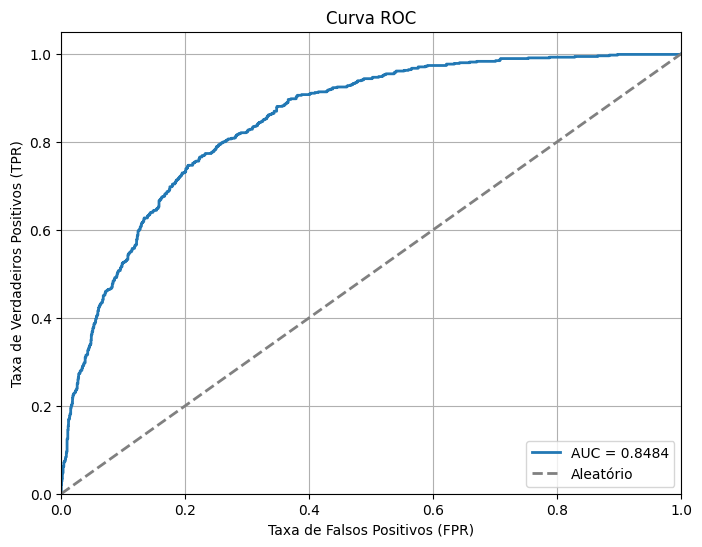

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 79.77%
Test F1-Score (Macro): 72.54%
Test KS Statistic: 54.1770% (p-value: 8.63e-126)

--- Evaluation Complete (Fold One) ---
Cleanup complete for Fold One.


In [51]:
print("\n--- KAN Final Evaluation on Test Set (Fold One) ---")
model.eval()
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np = y_test_tensor_cpu.numpy() 

with torch.no_grad():
    outputs_test = model(X_test_tensor) 
    if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
         print("Error: Final model evaluation failed - invalid output.")
         acc_test = 0.0
         f1_test = 0.0
         ks_statistic_test = np.nan
         roc_auc_test = np.nan
    else:
        probabilities_test = torch.softmax(outputs_test, dim=1)
        y_pred_test = torch.argmax(outputs_test, dim=1)
        y_pred_test_cpu = y_pred_test.cpu().numpy()

        try:
            if len(np.unique(y_test_cpu_np)) == 2: 
                y_probs_positive_class = probabilities_test[:, 1].cpu().numpy()
                fpr, tpr, _ = roc_curve(y_test_cpu_np, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC')
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
            print(f"Error during ROC calculation/plotting: {e}")
            roc_auc_test = np.nan

        if is_binary_final: 
            y_probs_test = y_probs_positive_class 
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")


if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")


print("\n--- Evaluation Complete (Fold One) ---")

del model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor_cpu
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Cleanup complete for Fold One.")

#### Fold Two

In [52]:
print("\n--- KAN Final Training & Evaluation using Best Hyperparameters (Fold Two) ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_np = X_train_fold_two.values if isinstance(X_train_fold_two, pd.DataFrame) else X_train_fold_two
y_train_np = y_train_fold_two.values if isinstance(y_train_fold_two, pd.Series) else y_train_fold_two
X_test_np = X_test_fold_two.values if isinstance(X_test_fold_two, pd.DataFrame) else X_test_fold_two
y_test_np = y_test_fold_two.values if isinstance(y_test_fold_two, pd.Series) else y_test_fold_two
X_val_np = X_val_fold_two.values if isinstance(X_val_fold_two, pd.DataFrame) else X_val_fold_two
y_val_np = y_val_fold_two.values if isinstance(y_val_fold_two, pd.Series) else y_val_fold_two

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor_cpu = torch.tensor(y_test_np, dtype=torch.long).cpu() 
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long).to(device)

if 'study_KAN' not in locals() or not hasattr(study_KAN, 'best_params'):
    print("Warning: KAN Optuna study 'study_KAN' not found or no best trial. Using default parameters.")
    best_params_KAN = {"hidden_neurons": 35, "grid_size": 3, "spline_order": 4, "learning_rate": 0.0088} 
else:
    best_params_KAN = study_KAN.best_params

hidden_neurons = best_params_KAN["hidden_neurons"]
grid_size = best_params_KAN["grid_size"]
spline_order = best_params_KAN["spline_order"]
learning_rate = best_params_KAN["learning_rate"]

input_size = X_train_np.shape[1]
unique_labels_train = np.unique(y_train_np)
output_size = len(unique_labels_train)
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, Hidden Neurons={hidden_neurons}, Grid={grid_size}, k={spline_order}, LR={learning_rate:.6f}")

is_binary_final = False
if output_size < 2:
    print("Error: Final training requires at least 2 classes. Check data.")
elif output_size == 2:
    is_binary_final = True

width = [input_size, hidden_neurons, output_size]
model = KAN(width=width, grid=grid_size, k=spline_order, device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_epochs_final = 100
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15
best_model_state_dict = None

print(f"\n--- Starting Final Training ({n_epochs_final} epochs) ---")
for epoch in range(n_epochs_final):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    current_val_loss = 0.0
    current_val_acc = 0.0
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        current_val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = torch.argmax(val_outputs, dim=1)
        current_val_acc = (val_preds == y_val_tensor).float().mean().item()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{n_epochs_final}, Train Loss: {loss.item():.4f}, Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        best_model_state_dict = model.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        if best_model_state_dict:
            model.load_state_dict(best_model_state_dict) 
            print("Loaded best model state based on validation accuracy.")
        break

if best_model_state_dict and epochs_no_improve < patience:
    model.load_state_dict(best_model_state_dict)
    print("Training finished. Loaded best model state based on validation accuracy.")

print("--- Final Training Finished ---")
print("-" * 40 + "\n")


--- KAN Final Training & Evaluation using Best Hyperparameters (Fold Two) ---
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, Hidden Neurons=25, Grid=10, k=3, LR=0.007316
checkpoint directory created: ./model
saving model version 0.0

--- Starting Final Training (100 epochs) ---
Epoch 10/100, Train Loss: 0.4894, Val Loss: 0.4855, Val Acc: 0.7242
Epoch 20/100, Train Loss: 0.4429, Val Loss: 0.4585, Val Acc: 0.7764
Epoch 30/100, Train Loss: 0.4256, Val Loss: 0.4418, Val Acc: 0.7827
Epoch 40/100, Train Loss: 0.4130, Val Loss: 0.4391, Val Acc: 0.7827

Early stopping at epoch 42.
Loaded best model state based on validation accuracy.
--- Final Training Finished ---
----------------------------------------




--- KAN Final Evaluation on Test Set (Fold Two) ---
Test ROC AUC: 0.8341


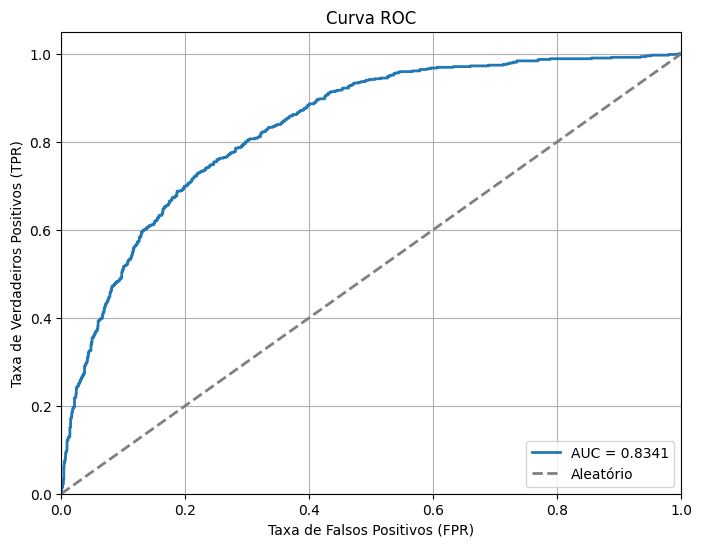

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 79.68%
Test F1-Score (Macro): 72.26%
Test KS Statistic: 50.9182% (p-value: 3.68e-108)

--- Evaluation Complete (Fold Two) ---
Cleanup complete for Fold Two.


In [55]:
print("\n--- KAN Final Evaluation on Test Set (Fold Two) ---")
model.eval()
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np = y_test_tensor_cpu.numpy() 

with torch.no_grad():
    outputs_test = model(X_test_tensor) 
    if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
         print("Error: Final model evaluation failed - invalid output.")
         acc_test = 0.0
         f1_test = 0.0
         ks_statistic_test = np.nan
         roc_auc_test = np.nan
    else:
        probabilities_test = torch.softmax(outputs_test, dim=1)
        y_pred_test = torch.argmax(outputs_test, dim=1)
        y_pred_test_cpu = y_pred_test.cpu().numpy()

        try:
            if len(np.unique(y_test_cpu_np)) == 2: 
                y_probs_positive_class = probabilities_test[:, 1].cpu().numpy()
                fpr, tpr, _ = roc_curve(y_test_cpu_np, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC')
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
            print(f"Error during ROC calculation/plotting: {e}")
            roc_auc_test = np.nan

        if len(np.unique(y_train_np)) == 2: 
            y_probs_test = y_probs_positive_class
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")


if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if len(np.unique(y_train_np)) == 2 and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")


print("\n--- Evaluation Complete (Fold Two) ---")

del model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor_cpu
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Cleanup complete for Fold Two.")

#### Fold Three

In [56]:
print("\n--- KAN Final Training & Evaluation using Best Hyperparameters (Fold Three) ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_np = X_train_fold_three.values if isinstance(X_train_fold_three, pd.DataFrame) else X_train_fold_three
y_train_np = y_train_fold_three.values if isinstance(y_train_fold_three, pd.Series) else y_train_fold_three
X_test_np = X_test_fold_three.values if isinstance(X_test_fold_three, pd.DataFrame) else X_test_fold_three
y_test_np = y_test_fold_three.values if isinstance(y_test_fold_three, pd.Series) else y_test_fold_three
X_val_np = X_val_fold_three.values if isinstance(X_val_fold_three, pd.DataFrame) else X_val_fold_three
y_val_np = y_val_fold_three.values if isinstance(y_val_fold_three, pd.Series) else y_val_fold_three

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor_cpu = torch.tensor(y_test_np, dtype=torch.long).cpu() 
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long).to(device)

if 'study_KAN' not in locals() or not hasattr(study_KAN, 'best_params'):
    print("Warning: KAN Optuna study 'study_KAN' not found or no best trial. Using default parameters.")
    best_params_KAN = {"hidden_neurons": 35, "grid_size": 3, "spline_order": 4, "learning_rate": 0.0088} 
else:
    best_params_KAN = study_KAN.best_params 

hidden_neurons = best_params_KAN["hidden_neurons"]
grid_size = best_params_KAN["grid_size"]
spline_order = best_params_KAN["spline_order"]
learning_rate = best_params_KAN["learning_rate"]

input_size = X_train_np.shape[1]
unique_labels_train = np.unique(y_train_np)
output_size = len(unique_labels_train)
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, Hidden Neurons={hidden_neurons}, Grid={grid_size}, k={spline_order}, LR={learning_rate:.6f}")

is_binary_final = False
if output_size < 2:
    print("Error: Final training requires at least 2 classes. Check data.")
elif output_size == 2:
    is_binary_final = True

width = [input_size, hidden_neurons, output_size]
model = KAN(width=width, grid=grid_size, k=spline_order, device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_epochs_final = 100
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15
best_model_state_dict = None

print(f"\n--- Starting Final Training ({n_epochs_final} epochs) ---")
for epoch in range(n_epochs_final):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    current_val_loss = 0.0
    current_val_acc = 0.0
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        current_val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = torch.argmax(val_outputs, dim=1)
        current_val_acc = (val_preds == y_val_tensor).float().mean().item()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{n_epochs_final}, Train Loss: {loss.item():.4f}, Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        best_model_state_dict = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        if best_model_state_dict:
            model.load_state_dict(best_model_state_dict) 
            print("Loaded best model state based on validation accuracy.")
        break

if best_model_state_dict and epochs_no_improve < patience:
    model.load_state_dict(best_model_state_dict)
    print("Training finished. Loaded best model state based on validation accuracy.")


print("--- Final Training Finished ---")
print("-" * 40 + "\n")


--- KAN Final Training & Evaluation using Best Hyperparameters (Fold Three) ---
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, Hidden Neurons=25, Grid=10, k=3, LR=0.007316
checkpoint directory created: ./model
saving model version 0.0

--- Starting Final Training (100 epochs) ---
Epoch 10/100, Train Loss: 0.4834, Val Loss: 0.4874, Val Acc: 0.7223
Epoch 20/100, Train Loss: 0.4379, Val Loss: 0.4669, Val Acc: 0.7777
Epoch 30/100, Train Loss: 0.4206, Val Loss: 0.4463, Val Acc: 0.7787
Epoch 40/100, Train Loss: 0.4110, Val Loss: 0.4404, Val Acc: 0.7872
Epoch 50/100, Train Loss: 0.4023, Val Loss: 0.4317, Val Acc: 0.7915
Epoch 60/100, Train Loss: 0.3920, Val Loss: 0.4301, Val Acc: 0.7979
Epoch 70/100, Train Loss: 0.3784, Val Loss: 0.4343, Val Acc: 0.7947
Epoch 80/100, Train Loss: 0.3591, Val Loss: 0.4451, Val Acc: 0.7862

Early stopping at epoch 82.
Loaded best model state based on validation accuracy.
--- Final Training Finished ---
-------------------------------------


--- KAN Final Evaluation on Test Set (Fold Three) ---
Test ROC AUC: 0.8262


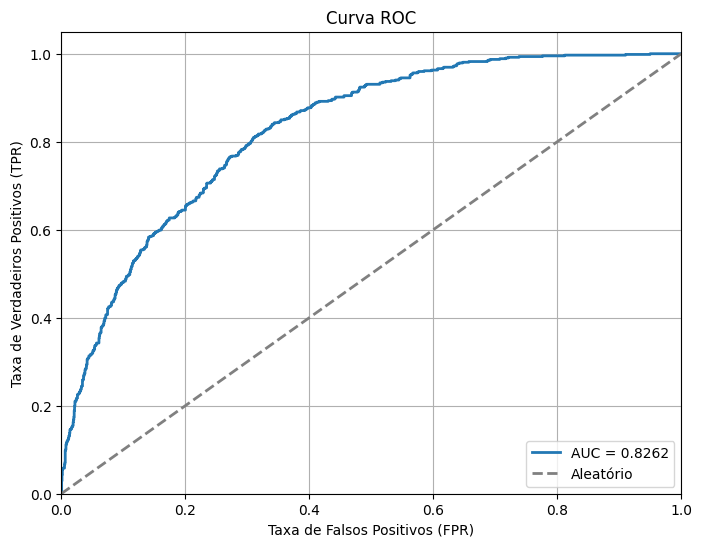

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 78.74%
Test F1-Score (Macro): 70.83%
Test KS Statistic: 49.9763% (p-value: 2.13e-104)

--- Evaluation Complete (Fold Three) ---
Cleanup complete for Fold Three.


In [57]:
print("\n--- KAN Final Evaluation on Test Set (Fold Three) ---")
model.eval()
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np = y_test_tensor_cpu.numpy() 

with torch.no_grad():
    outputs_test = model(X_test_tensor) 
    if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
         print("Error: Final model evaluation failed - invalid output.")
         acc_test = 0.0
         f1_test = 0.0
         ks_statistic_test = np.nan
         roc_auc_test = np.nan
    else:
        probabilities_test = torch.softmax(outputs_test, dim=1)
        y_pred_test = torch.argmax(outputs_test, dim=1)
        y_pred_test_cpu = y_pred_test.cpu().numpy()

        try:
            if len(np.unique(y_test_cpu_np)) == 2: 
                y_probs_positive_class = probabilities_test[:, 1].cpu().numpy()
                fpr, tpr, _ = roc_curve(y_test_cpu_np, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC') 
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
            print(f"Error during ROC calculation/plotting: {e}")
            roc_auc_test = np.nan

        if len(np.unique(y_train_np)) == 2: 
            y_probs_test = y_probs_positive_class
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if len(np.unique(y_train_np)) == 2 and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")

print("\n--- Evaluation Complete (Fold Three) ---")

del model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor_cpu
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Cleanup complete for Fold Three.")

## *Transformer*

### Parâmetros que serão variados

In [58]:
import torch.nn.functional as F
import optuna
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import ks_2samp

class StochasticTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(StochasticTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)  
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.output_proj(x)

### Otimização com Optuna

In [59]:
from scipy.stats import ks_2samp

def objective_transformer(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    d_model = trial.suggest_categorical("d_model", [32, 64, 128])
    nhead = trial.suggest_categorical("nhead", [2, 4, 8])
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    input_size = X_train_fold_one.shape[1]
    output_size = len(np.unique(y_train_fold_one))

    model = StochasticTransformer(input_size, output_size, d_model=d_model, nhead=nhead,
                                  num_layers=num_layers, dropout=dropout).to(device)

    X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(50):  
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        y_probs = probabilities[:, 1].cpu().numpy()  
        y_true = y_test_tensor.cpu().numpy()

    ks_statistic, _ = ks_2samp(y_probs[y_true == 1], y_probs[y_true == 0])
    return ks_statistic


In [60]:
study_transformer = optuna.create_study(direction="maximize")
study_transformer.optimize(objective_transformer, n_trials=50)
print("Melhores hiperparâmetros:", study_transformer.best_params)

[I 2025-04-14 10:39:33,829] A new study created in memory with name: no-name-671d25fc-3700-4e93-a413-7f4348753f34
[I 2025-04-14 10:39:36,660] Trial 0 finished with value: 0.5470781563863186 and parameters: {'d_model': 32, 'nhead': 8, 'num_layers': 3, 'dropout': 0.3021396601100329, 'learning_rate': 0.0004121612417931476}. Best is trial 0 with value: 0.5470781563863186.
[I 2025-04-14 10:39:37,916] Trial 1 finished with value: 0.4639656908035357 and parameters: {'d_model': 32, 'nhead': 2, 'num_layers': 4, 'dropout': 0.419525131194583, 'learning_rate': 0.004023525639024617}. Best is trial 0 with value: 0.5470781563863186.
[I 2025-04-14 10:39:39,740] Trial 2 finished with value: 0.5274606873790514 and parameters: {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dropout': 0.2887557169087607, 'learning_rate': 0.0021263313527425426}. Best is trial 0 with value: 0.5470781563863186.
[I 2025-04-14 10:39:40,663] Trial 3 finished with value: 0.5321299373480242 and parameters: {'d_model': 128, 'nhead'

Melhores hiperparâmetros: {'d_model': 128, 'nhead': 4, 'num_layers': 3, 'dropout': 0.190561365391532, 'learning_rate': 0.00013585142018156195}


### Treinamento do modelo

In [61]:
# Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]

# Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
X_val_fold_two = dfValFoldTwo.drop("Churn", axis=1)
y_val_fold_two = dfValFoldTwo["Churn"]

# Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]
X_val_fold_three = dfValFoldThree.drop("Churn", axis=1)
y_val_fold_three = dfValFoldThree["Churn"]

#### Fold One

In [62]:
best_params = study_transformer.best_params

d_model = best_params["d_model"]
nhead = best_params["nhead"]
num_layers = best_params["num_layers"]
dropout = best_params["dropout"]
learning_rate = best_params["learning_rate"]

input_size = X_train_fold_one.shape[1]
output_size = len(torch.unique(torch.tensor(y_train_fold_one.to_numpy())))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = StochasticTransformer(input_size, output_size, d_model=d_model, nhead=nhead,
                              num_layers=num_layers, dropout=dropout).to(device)

X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_one.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
print("\nStochastic Transformer Fold One: \n")
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()

    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")


Stochastic Transformer Fold One: 

Epoch 1, Train Loss: 0.8592, Val Loss: 0.5779, Val Acc: 0.7412
Epoch 2, Train Loss: 0.5942, Val Loss: 0.5872, Val Acc: 0.7412
Epoch 3, Train Loss: 0.5978, Val Loss: 0.5848, Val Acc: 0.7412
Epoch 4, Train Loss: 0.5962, Val Loss: 0.5410, Val Acc: 0.7412
Epoch 5, Train Loss: 0.5558, Val Loss: 0.4848, Val Acc: 0.7583
Epoch 6, Train Loss: 0.5004, Val Loss: 0.4479, Val Acc: 0.7721
Epoch 7, Train Loss: 0.4657, Val Loss: 0.4464, Val Acc: 0.7849
Epoch 8, Train Loss: 0.4593, Val Loss: 0.4670, Val Acc: 0.7710
Epoch 9, Train Loss: 0.4745, Val Loss: 0.4816, Val Acc: 0.7593
Epoch 10, Train Loss: 0.4901, Val Loss: 0.4775, Val Acc: 0.7572
Epoch 11, Train Loss: 0.4845, Val Loss: 0.4608, Val Acc: 0.7753
Epoch 12, Train Loss: 0.4671, Val Loss: 0.4437, Val Acc: 0.7881
Epoch 13, Train Loss: 0.4495, Val Loss: 0.4350, Val Acc: 0.7891
Epoch 14, Train Loss: 0.4399, Val Loss: 0.4357, Val Acc: 0.7902
Epoch 15, Train Loss: 0.4433, Val Loss: 0.4408, Val Acc: 0.7923
Epoch 16, Tra


--- Transformer Final Evaluation on Test Set (Fold One) ---
Test ROC AUC: 0.8502


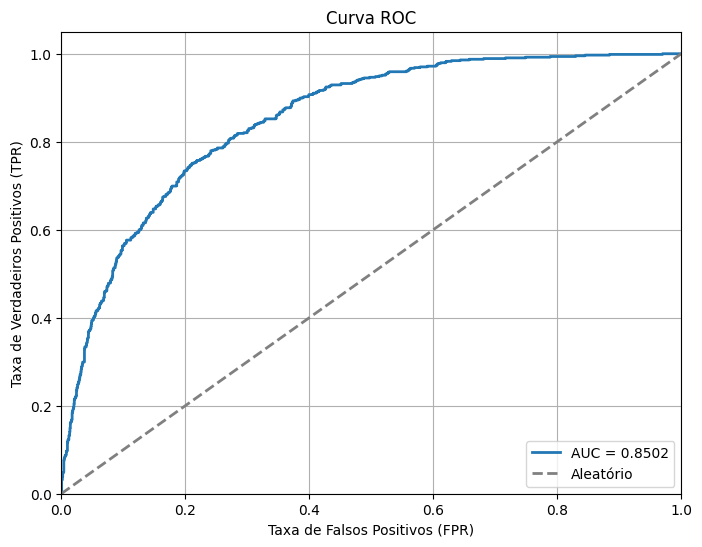

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 80.20%
Test F1-Score (Macro): 74.19%
Test KS Statistic: 53.9856% (p-value: 7.51e-125)

--- Evaluation Complete (Fold One) ---
Cleanup complete for Fold One.


In [63]:
print("\n--- Transformer Final Evaluation on Test Set (Fold One) ---")
model.eval()
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np = y_test_tensor.cpu().numpy()

with torch.no_grad():
    outputs_test = model(X_test_tensor) 
    if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
         print("Error: Final model evaluation failed - invalid output.")
         acc_test = 0.0
         f1_test = 0.0
         ks_statistic_test = np.nan
         roc_auc_test = np.nan
    else:
        probabilities_test = torch.softmax(outputs_test, dim=1)
        y_pred_test = torch.argmax(outputs_test, dim=1)
        y_pred_test_cpu = y_pred_test.cpu().numpy()

        try:
            if output_size == 2:
                y_probs_positive_class = probabilities_test[:, 1].cpu().numpy()
                fpr, tpr, _ = roc_curve(y_test_cpu_np, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC') 
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
             print(f"Error during ROC calculation/plotting: {e}")
             roc_auc_test = np.nan

        if output_size == 2:
            y_probs_test = y_probs_positive_class
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if output_size == 2 and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")

print("\n--- Evaluation Complete (Fold One) ---")

del model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Cleanup complete for Fold One.")

#### Fold Two

In [64]:
print("\nStochastic Transformer Fold Two: \n")

if 'study_transformer' not in locals() or not hasattr(study_transformer, 'best_params'):
    print("Warning: Transformer Optuna study 'study_transformer' not found or no best trial. Using default parameters.")
    best_params_transformer = {"d_model": 128, "nhead": 2, "num_layers": 4, "dropout": 0.276, "learning_rate": 2.52e-05} 
else:
    best_params_transformer = study_transformer.best_params 

d_model = best_params_transformer["d_model"]
nhead = best_params_transformer["nhead"]
num_layers = best_params_transformer["num_layers"]
dropout = best_params_transformer["dropout"]
learning_rate = best_params_transformer["learning_rate"]

input_size = X_train_fold_two.shape[1]
output_size = len(torch.unique(torch.tensor(y_train_fold_two.to_numpy())))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = StochasticTransformer(input_size, output_size, d_model=d_model, nhead=nhead,
                              num_layers=num_layers, dropout=dropout).to(device)

X_train_tensor = torch.tensor(X_train_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_two.to_numpy(), dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_two.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_two.to_numpy(), dtype=torch.long)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epochs_final = 100 
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_state_dict = None

for epoch in range(n_epochs_final):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    current_val_loss = 0.0
    current_val_acc = 0.0
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        current_val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = torch.argmax(val_outputs, dim=1)
        current_val_acc = (val_preds == y_val_tensor).float().mean().item()

    if (epoch + 1) % 10 == 0: 
        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        best_model_state_dict = model.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        if best_model_state_dict:
            model.load_state_dict(best_model_state_dict)
            print("Loaded best model state based on validation accuracy.")
        break

if best_model_state_dict and epochs_no_improve < patience:
    model.load_state_dict(best_model_state_dict)
    print("Training finished. Loaded best model state based on validation accuracy.")


Stochastic Transformer Fold Two: 

Epoch 10, Train Loss: 0.4527, Val Loss: 0.4830, Val Acc: 0.7636
Epoch 20, Train Loss: 0.4311, Val Loss: 0.4472, Val Acc: 0.7827
Epoch 30, Train Loss: 0.4272, Val Loss: 0.4416, Val Acc: 0.7838
Epoch 40, Train Loss: 0.4257, Val Loss: 0.4421, Val Acc: 0.7838

Early stopping at epoch 41.
Loaded best model state based on validation accuracy.



--- Transformer Final Evaluation on Test Set (Fold Two) ---
Test ROC AUC: 0.8304


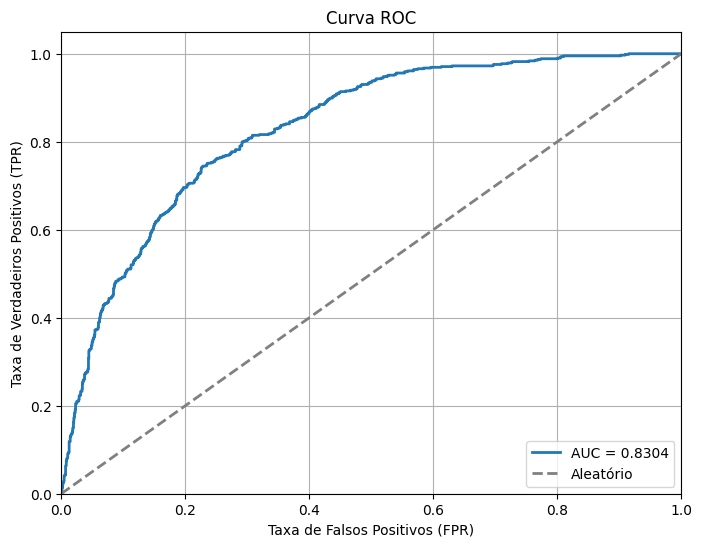

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 79.00%
Test F1-Score (Macro): 71.33%
Test KS Statistic: 51.6210% (p-value: 2.5e-111)

--- Evaluation Complete (Fold Two) ---
Cleanup complete for Fold Two.


In [65]:
print("\n--- Transformer Final Evaluation on Test Set (Fold Two) ---")
model.eval()
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np = y_test_tensor.numpy() 

with torch.no_grad():
    outputs_test = model(X_test_tensor.to(device)) 
    if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
         print("Error: Final model evaluation failed - invalid output.")
         acc_test = 0.0
         f1_test = 0.0
         ks_statistic_test = np.nan
         roc_auc_test = np.nan
    else:
        probabilities_test = torch.softmax(outputs_test, dim=1)
        y_pred_test = torch.argmax(outputs_test, dim=1)
        y_pred_test_cpu = y_pred_test.cpu().numpy()

        try:
            if output_size == 2:
                y_probs_positive_class = probabilities_test[:, 1].cpu().numpy()
                fpr, tpr, _ = roc_curve(y_test_cpu_np, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC') 
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
             print(f"Error during ROC calculation/plotting: {e}")
             roc_auc_test = np.nan

        if output_size == 2:
            y_probs_test = y_probs_positive_class
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if output_size == 2 and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")

print("\n--- Evaluation Complete (Fold Two) ---")

del model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Cleanup complete for Fold Two.")

#### Fold Three

In [66]:
print("\nStochastic Transformer Fold Three: \n")

if 'study_transformer' not in locals() or not hasattr(study_transformer, 'best_params'):
    print("Warning: Transformer Optuna study 'study_transformer' not found or no best trial. Using default parameters.")
    best_params_transformer = {"d_model": 128, "nhead": 2, "num_layers": 4, "dropout": 0.276, "learning_rate": 2.52e-05} 
else:
    best_params_transformer = study_transformer.best_params 

d_model = best_params_transformer["d_model"]
nhead = best_params_transformer["nhead"]
num_layers = best_params_transformer["num_layers"]
dropout = best_params_transformer["dropout"]
learning_rate = best_params_transformer["learning_rate"]

input_size = X_train_fold_three.shape[1]
output_size = len(torch.unique(torch.tensor(y_train_fold_three.to_numpy())))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = StochasticTransformer(input_size, output_size, d_model=d_model, nhead=nhead,
                              num_layers=num_layers, dropout=dropout).to(device)

X_train_tensor = torch.tensor(X_train_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_three.to_numpy(), dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_three.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_three.to_numpy(), dtype=torch.long)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epochs_final = 100
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_state_dict = None

for epoch in range(n_epochs_final):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    current_val_loss = 0.0
    current_val_acc = 0.0
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        current_val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = torch.argmax(val_outputs, dim=1)
        current_val_acc = (val_preds == y_val_tensor).float().mean().item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        best_model_state_dict = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        if best_model_state_dict:
            model.load_state_dict(best_model_state_dict)
            print("Loaded best model state based on validation accuracy.")
        break

if best_model_state_dict and epochs_no_improve < patience:
    model.load_state_dict(best_model_state_dict)
    print("Training finished. Loaded best model state based on validation accuracy.")


Stochastic Transformer Fold Three: 

Epoch 10, Train Loss: 0.4681, Val Loss: 0.5066, Val Acc: 0.7277
Epoch 20, Train Loss: 0.4521, Val Loss: 0.4808, Val Acc: 0.7660
Epoch 30, Train Loss: 0.4285, Val Loss: 0.4536, Val Acc: 0.7713
Epoch 40, Train Loss: 0.4225, Val Loss: 0.4500, Val Acc: 0.7734

Early stopping at epoch 43.
Loaded best model state based on validation accuracy.



--- Transformer Final Evaluation on Test Set (Fold Three) ---
Test ROC AUC: 0.8227


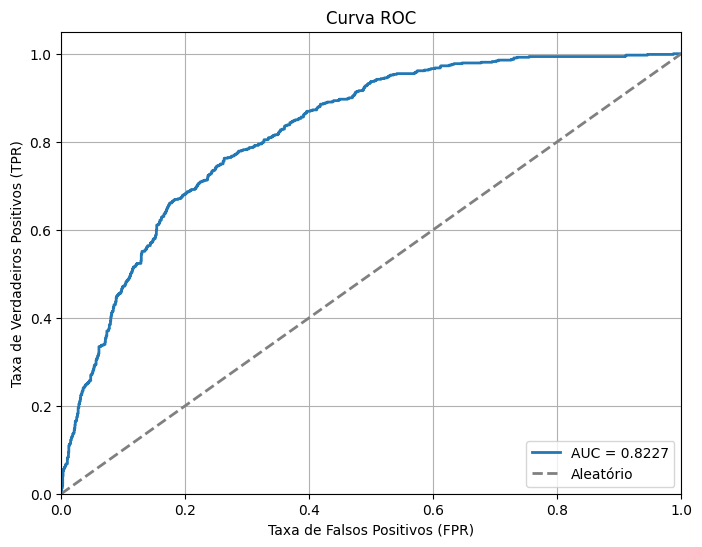

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 78.31%
Test F1-Score (Macro): 72.40%
Test KS Statistic: 49.9789% (p-value: 2.05e-104)

--- Evaluation Complete (Fold Three) ---
Cleanup complete for Fold Three.


In [67]:
print("\n--- Transformer Final Evaluation on Test Set (Fold Three) ---")
model.eval()
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np = y_test_tensor.numpy() 

with torch.no_grad():
    outputs_test = model(X_test_tensor.to(device)) 
    if outputs_test is None or not isinstance(outputs_test, torch.Tensor):
         print("Error: Final model evaluation failed - invalid output.")
         acc_test = 0.0
         f1_test = 0.0
         ks_statistic_test = np.nan
         roc_auc_test = np.nan
    else:
        probabilities_test = torch.softmax(outputs_test, dim=1)
        y_pred_test = torch.argmax(outputs_test, dim=1)
        y_pred_test_cpu = y_pred_test.cpu().numpy()

        try:
            if output_size == 2:
                y_probs_positive_class = probabilities_test[:, 1].cpu().numpy()
                fpr, tpr, _ = roc_curve(y_test_cpu_np, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC')
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
             print(f"Error during ROC calculation/plotting: {e}")
             roc_auc_test = np.nan

        if output_size == 2:
            y_probs_test = y_probs_positive_class
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if output_size == 2 and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np == 0]
                class1_probs = y_probs_test[y_test_cpu_np == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")

print("\n--- Evaluation Complete (Fold Three) ---")

del model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Cleanup complete for Fold Three.")

## *STab*

### Parâmetros que serão variados

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import optuna
import keras4torch
import gc 
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ks_2samp
from scipy.special import softmax as scipy_softmax 
from STAB.mainmodel import MainModel
from STAB.LWTA import LWTA, Gsoftmax
from STAB.model_wrapper import Num_Cat
from keras4torch.callbacks import ModelCheckpoint, LRScheduler, EarlyStopping

In [69]:
# Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]

# Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
X_val_fold_two = dfValFoldTwo.drop("Churn", axis=1)
y_val_fold_two = dfValFoldTwo["Churn"]

# Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]
X_val_fold_three = dfValFoldThree.drop("Churn", axis=1)
y_val_fold_three = dfValFoldThree["Churn"]

### Otimização com Optuna

In [70]:
def objective_STab_Cuda_KS(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dim = trial.suggest_categorical("dim", [32, 64]) 
    depth = trial.suggest_int("depth", 1, 4)         
    heads = trial.suggest_categorical("heads", [2, 4]) 
    if dim % heads != 0:
        possible_heads = [h for h in [2, 4] if dim % h == 0]
        if not possible_heads:
             raise optuna.exceptions.TrialPruned("No valid head count for the suggested dimension.")
        heads = trial.suggest_categorical("adjusted_heads", possible_heads)

    attn_dropout = trial.suggest_float("attn_dropout", 0.0, 0.4) 
    ff_dropout = trial.suggest_float("ff_dropout", 0.0, 0.4)   
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    U_param = 2
    cases_param = 8

    X_train_np = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
    y_train_np = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
    X_test_np = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
    y_test_np = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one

    num_continuous_features = X_train_np.shape[1]
    unique_labels = np.unique(y_train_np)
    output_size = len(unique_labels)

    is_binary = False
    if output_size != 2: 
        print(f"Trial {trial.number}: Not binary classification. KS requires binary.")
        return 0.0

    stab_original_model = None
    stab_wrapped_model = None
    model = None
    objective_batch_size = 64 
    predict_batch_size = 128 

    try:
        stab_original_model = MainModel(
            categories=(), num_continuous=num_continuous_features, dim=dim, dim_out=output_size,
            depth=depth, heads=heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout,
            U=U_param, cases=cases_param,
        )
        stab_wrapped_model = Num_Cat(
            stab_original_model, num_number=num_continuous_features, classes=output_size,
            Sample_size=objective_batch_size
        )
        model = keras4torch.Model(stab_wrapped_model).build([num_continuous_features])
        model.to(device)

    except Exception as e:
        print(f"Error creating STab model in trial {trial.number}: {e}")
        del stab_original_model, stab_wrapped_model, model; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return 0.0 

    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
    y_test_cpu_np = y_test_np

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    model.compile(optimizer=optimizer, loss='ce_loss', metrics=['accuracy'])

    n_epochs = 30 

    test_logits = None
    probabilities_test = None
    y_probs_test = None
    ks_stat = 0.0

    try:
        try:
            model.fit([X_train_tensor], y_train_tensor,
                      epochs=n_epochs,
                      batch_size=objective_batch_size,
                      verbose=0) 
        except Exception as e:
            print(f"Error during training in trial {trial.number}: {e}")
            raise e 

        try:
            test_logits = model.predict([X_test_tensor], batch_size=predict_batch_size) 
            if test_logits is None or not isinstance(test_logits, np.ndarray):
                 raise ValueError("Invalid model prediction during evaluation.")

            probabilities_test = scipy_softmax(test_logits, axis=1)
            y_probs_test = probabilities_test[:, 1] 

            if len(np.unique(y_test_cpu_np)) == 2:
                try:
                    class0_probs = y_probs_test[y_test_cpu_np == 0]
                    class1_probs = y_probs_test[y_test_cpu_np == 1]
                    if len(class0_probs) > 0 and len(class1_probs) > 0:
                         ks_statistic_val, _ = ks_2samp(class1_probs, class0_probs)
                         ks_stat = ks_statistic_val
                    else: pass 
                except ValueError as e: print(f"Error calculating KS in trial {trial.number}: {e}")
            else: pass 

        except Exception as e:
            print(f"Error during evaluation in trial {trial.number}: {e}")
            ks_stat = 0.0 

    finally:
        variables_to_delete = [
            'stab_original_model', 'stab_wrapped_model', 'model',
            'X_train_tensor', 'y_train_tensor', 'X_test_tensor',
            'test_logits', 'probabilities_test', 'y_probs_test',
            'optimizer'
        ]
        for var_name in variables_to_delete:
            if var_name in locals():
                try:
                    del locals()[var_name]
                except NameError: 
                    pass
            if var_name in globals(): 
                 try:
                    del globals()[var_name]
                 except NameError:
                    pass


        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return ks_stat

study_STab = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study_STab.optimize(objective_STab_Cuda_KS, n_trials=5, timeout=1200) 

[I 2025-04-14 10:45:13,720] A new study created in memory with name: no-name-720dd855-4ebf-44e4-bebb-da8f363fedaa
[I 2025-04-14 10:49:09,104] Trial 0 finished with value: 0.5488423404167299 and parameters: {'dim': 32, 'depth': 4, 'heads': 2, 'attn_dropout': 0.11444429680574215, 'ff_dropout': 0.1426552530912853, 'learning_rate': 0.0003948623608242509}. Best is trial 0 with value: 0.5488423404167299.


### Treinamento do modelo

#### Fold One

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_np = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
y_train_np = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
X_test_np = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
y_test_np = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one
X_val_np = X_val_fold_one.values if isinstance(X_val_fold_one, pd.DataFrame) else X_val_fold_one
y_val_np = y_val_fold_one.values if isinstance(y_val_fold_one, pd.Series) else y_val_fold_one

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor_cpu = torch.tensor(y_test_np, dtype=torch.long).cpu() 
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.long).to(device)

if 'best_params_STab' not in locals() or not study_STab.best_trial:
     print("No best trial found from Optuna. Using default parameters.")
     best_params_STab = {"dim": 64, "depth": 3, "heads": 4, "attn_dropout": 0.1, "ff_dropout": 0.1, "learning_rate": 0.001}
else:
     best_params_STab = study_STab.best_params

dim = best_params_STab["dim"]
depth = best_params_STab["depth"]
heads = best_params_STab["heads"]
attn_dropout = best_params_STab["attn_dropout"]
ff_dropout = best_params_STab["ff_dropout"]
learning_rate = best_params_STab["learning_rate"]
U_param = 2
cases_param = 8

input_size = X_train_np.shape[1]
unique_labels_train = np.unique(y_train_np)
output_size = len(unique_labels_train)
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, Dim={dim}, Depth={depth}, Heads={heads}, AttnDrop={attn_dropout:.2f}, FFDrop={ff_dropout:.2f}, LR={learning_rate:.6f}")

is_binary_final = False
if output_size < 2: print("Error: Final training requires at least 2 classes."); exit()
elif output_size == 2: is_binary_final = True

final_batch_size = 8 
if dim % heads != 0:
    print(f"Warning: Final 'dim' ({dim}) not divisible by 'heads' ({heads}). Adjusting heads.")
    possible_heads = [h for h in [2, 4, 8] if dim % h == 0]
    heads = possible_heads[0] if possible_heads else (2 if dim % 2 == 0 else 1) 
    print(f"Adjusted heads to: {heads}")


stab_original_model_final = MainModel(
    categories=(), num_continuous=input_size, dim=dim, dim_out=output_size,
    depth=depth, heads=heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout,
    U=U_param, cases=cases_param,
)
stab_wrapped_model_final = Num_Cat(
    stab_original_model_final, num_number=input_size, classes=output_size,
    Sample_size=final_batch_size
)
model_final = keras4torch.Model(stab_wrapped_model_final).build([input_size])
model_final.to(device)

optimizer_final = torch.optim.AdamW(model_final.parameters(), lr=learning_rate)
model_final.compile(optimizer=optimizer_final, loss='ce_loss', metrics=['accuracy']) 

n_epochs_final = 5
patience_final = 15

early_stopping = EarlyStopping(monitor='val_acc', patience=patience_final, mode='max', verbose=1)

history_final = model_final.fit(
    [X_train_tensor], y_train_tensor,
    epochs=n_epochs_final,
    batch_size=final_batch_size,
    validation_data=([X_val_tensor], y_val_tensor),
    callbacks=[early_stopping],
    verbose=2
)

Using device: cuda
No best trial found from Optuna. Using default parameters.
Final Model Config: Input Size=39, Output Size=2, Dim=64, Depth=3, Heads=4, AttnDrop=0.10, FFDrop=0.10, LR=0.001000
Train on 3756 samples, validate on 939 samples:
 - 34s - loss: 0.4719 - acc: 0.7636 - val_loss: 0.4369 - val_acc: 0.7891 - lr: 1e-03
Epoch 2/5 - 44s - loss: 0.4522 - acc: 0.7796 - val_loss: 0.4368 - val_acc: 0.8009 - lr: 1e-03
Epoch 3/5 - 43s - loss: 0.4430 - acc: 0.7819 - val_loss: 0.4459 - val_acc: 0.7913 - lr: 1e-03
Epoch 4/5 - 42s - loss: 0.4442 - acc: 0.7838 - val_loss: 0.4368 - val_acc: 0.7838 - lr: 1e-03
Epoch 5/5 - 50s - loss: 0.4395 - acc: 0.7891 - val_loss: 0.4340 - val_acc: 0.7881 - lr: 1e-03



--- STab Final Evaluation on Test Set (Fold One) ---
Test ROC AUC: 0.8478


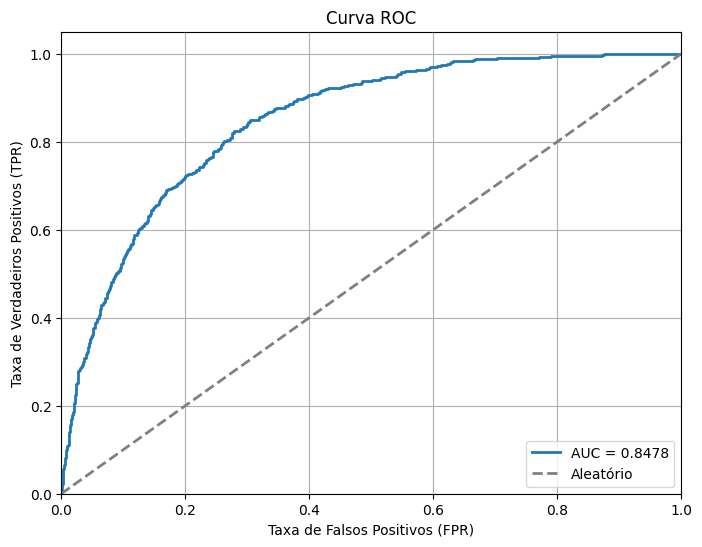

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 80.07%
Test F1-Score (Macro): 74.20%
Test KS Statistic: 54.5163% (p-value: 1.83e-127)

--- Evaluation Complete (Fold One) ---
Final cleanup complete for Fold One.


In [72]:
print("\n--- STab Final Evaluation on Test Set (Fold One) ---")
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np_final = y_test_tensor_cpu.numpy()
predict_batch_size = 128 

try:
    test_logits = model_final.predict([X_test_tensor], batch_size=predict_batch_size) 
    if test_logits is None or not isinstance(test_logits, np.ndarray):
         raise ValueError("Invalid model prediction during final evaluation.")
    else:
        probabilities_test = scipy_softmax(test_logits, axis=1) 
        y_pred_test = np.argmax(probabilities_test, axis=1)
        y_pred_test_cpu = y_pred_test

        try:
            if is_binary_final:
                y_probs_positive_class = probabilities_test[:, 1]
                fpr, tpr, _ = roc_curve(y_test_cpu_np_final, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC')
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
            print(f"Error during ROC calculation/plotting: {e}")
            roc_auc_test = np.nan

        if is_binary_final:
            y_probs_test = y_probs_positive_class
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")

except Exception as e:
    print(f"Error during final prediction: {e}")
    acc_test = 0.0
    f1_test = 0.0
    ks_statistic_test = np.nan
    roc_auc_test = np.nan

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np_final, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np_final, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np_final)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np_final == 0]
                class1_probs = y_probs_test[y_test_cpu_np_final == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")


print("\n--- Evaluation Complete (Fold One) ---")

try:
    if 'stab_original_model_final' in locals(): del stab_original_model_final
    if 'stab_wrapped_model_final' in locals(): del stab_wrapped_model_final
    if 'model_final' in locals(): del model_final
    if 'optimizer_final' in locals(): del optimizer_final
    if 'history_final' in locals(): del history_final
    del X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor_cpu
    if 'train_dataset_for_fit' in locals(): del train_dataset_for_fit
    if 'val_dataset_for_fit' in locals(): del val_dataset_for_fit
    if 'test_logits' in locals(): del test_logits
    if 'probabilities_test' in locals(): del probabilities_test
    if 'y_probs_test' in locals(): del y_probs_test
    if 'y_pred_test_cpu' in locals(): del y_pred_test_cpu
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Final cleanup complete for Fold One.")
except Exception as e:
    print(f"Error during final cleanup for Fold One: {e}")

#### Fold Two

In [73]:
print("\n--- STab Final Training & Evaluation using Best Hyperparameters (Fold Two) ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_np_final = X_train_fold_two.values if isinstance(X_train_fold_two, pd.DataFrame) else X_train_fold_two
y_train_np_final = y_train_fold_two.values if isinstance(y_train_fold_two, pd.Series) else y_train_fold_two
X_test_np_final = X_test_fold_two.values if isinstance(X_test_fold_two, pd.DataFrame) else X_test_fold_two
y_test_np_final = y_test_fold_two.values if isinstance(y_test_fold_two, pd.Series) else y_test_fold_two
X_val_np_final = X_val_fold_two.values if isinstance(X_val_fold_two, pd.DataFrame) else X_val_fold_two
y_val_np_final = y_val_fold_two.values if isinstance(y_val_fold_two, pd.Series) else y_val_fold_two

X_train_tensor = torch.tensor(X_train_np_final, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np_final, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np_final, dtype=torch.float32).to(device)
y_test_tensor_cpu = torch.tensor(y_test_np_final, dtype=torch.long).cpu()
X_val_tensor = torch.tensor(X_val_np_final, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np_final, dtype=torch.long).to(device)

if 'study_STab' not in locals() or not hasattr(study_STab, 'best_params') or not study_STab.best_trial:
    print("Warning: STab Optuna study 'study_STab' not found or no best trial. Using default parameters.")
    best_params_STab = {'dim': 32, 'depth': 1, 'heads': 2, 'attn_dropout': 0.09818226201678813, 'ff_dropout': 0.34399717521649803, 'learning_rate': 2.8718316162877778e-05}
else:
    best_params_STab = study_STab.best_params

dim = best_params_STab["dim"]
depth = best_params_STab["depth"]
heads = best_params_STab["heads"]
attn_dropout = best_params_STab["attn_dropout"]
ff_dropout = best_params_STab["ff_dropout"]
learning_rate = best_params_STab["learning_rate"]
U_param = 2
cases_param = 8

input_size = X_train_np_final.shape[1]
output_size = len(np.unique(y_train_np_final))
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, Dim={dim}, Depth={depth}, Heads={heads}, AttnDrop={attn_dropout:.2f}, FFDrop={ff_dropout:.2f}, LR={learning_rate:.6f}")

is_binary_final = (output_size == 2)
if not is_binary_final: print("Warning: Final eval - KS requires binary.")

final_batch_size = 64
if dim % heads != 0:
    print(f"Warning: Final 'dim' ({dim}) not divisible by 'heads' ({heads}). Adjusting heads.")
    possible_heads = [h for h in [2, 4, 8] if dim % h == 0]
    heads = possible_heads[0] if possible_heads else (2 if dim % 2 == 0 else 1)
    print(f"Adjusted heads to: {heads}")

stab_original_model_final = MainModel(
    categories=(), num_continuous=input_size, dim=dim, dim_out=output_size,
    depth=depth, heads=heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout,
    U=U_param, cases=cases_param,
)
stab_wrapped_model_final = Num_Cat(
    stab_original_model_final, num_number=input_size, classes=output_size,
    Sample_size=final_batch_size 
)
model_final = keras4torch.Model(stab_wrapped_model_final).build([input_size])
model_final.to(device)

optimizer_final = torch.optim.AdamW(model_final.parameters(), lr=learning_rate)
model_final.compile(optimizer=optimizer_final, loss='ce_loss', metrics=['accuracy'])

n_epochs_final = 100 
patience_final = 15 

early_stopping = EarlyStopping(monitor='val_acc', patience=patience_final, mode='max', verbose=1)

train_dataset_for_fit = ([X_train_tensor], y_train_tensor)
val_dataset_for_fit = ([X_val_tensor], y_val_tensor)

history_final = model_final.fit(
    train_dataset_for_fit[0], train_dataset_for_fit[1], 
    epochs=n_epochs_final,
    batch_size=final_batch_size,                     
    validation_data=val_dataset_for_fit,              
    callbacks=[early_stopping],
    verbose=2
)


--- STab Final Training & Evaluation using Best Hyperparameters (Fold Two) ---
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, Dim=32, Depth=4, Heads=2, AttnDrop=0.11, FFDrop=0.14, LR=0.000395
Train on 3756 samples, validate on 939 samples:
 - 10s - loss: 0.5243 - acc: 0.7420 - val_loss: 0.4766 - val_acc: 0.7561 - lr: 3.9e-04
Epoch 2/100 - 5.6s - loss: 0.4758 - acc: 0.7591 - val_loss: 0.4681 - val_acc: 0.7380 - lr: 3.9e-04
Epoch 3/100 - 6.9s - loss: 0.4674 - acc: 0.7569 - val_loss: 0.4545 - val_acc: 0.7636 - lr: 3.9e-04
Epoch 4/100 - 7.6s - loss: 0.4533 - acc: 0.7670 - val_loss: 0.4496 - val_acc: 0.7710 - lr: 3.9e-04
Epoch 5/100 - 10s - loss: 0.4505 - acc: 0.7697 - val_loss: 0.4474 - val_acc: 0.7785 - lr: 3.9e-04
Epoch 6/100 - 7.1s - loss: 0.4486 - acc: 0.7772 - val_loss: 0.4529 - val_acc: 0.7604 - lr: 3.9e-04
Epoch 7/100 - 10s - loss: 0.4487 - acc: 0.7705 - val_loss: 0.4535 - val_acc: 0.7561 - lr: 3.9e-04
Epoch 8/100 - 9.5s - loss: 0.4425 - acc: 0.7734 - val_loss


--- STab Final Evaluation on Test Set (Fold Two) ---
Test ROC AUC: 0.8430


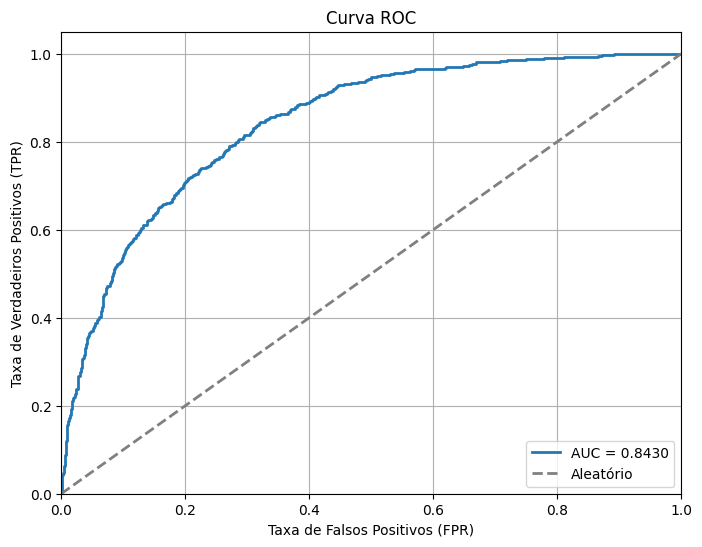

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 80.15%
Test F1-Score (Macro): 70.31%
Test KS Statistic: 52.3649% (p-value: 1.01e-114)

--- Evaluation Complete (Fold Two) ---
Final cleanup complete for Fold Two.


In [74]:
print("\n--- STab Final Evaluation on Test Set (Fold Two) ---")
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np_final = y_test_tensor_cpu.numpy() 
predict_batch_size = 128

try:
    test_logits = model_final.predict([X_test_tensor], batch_size=predict_batch_size)
    if test_logits is None or not isinstance(test_logits, np.ndarray):
         raise ValueError("Invalid model prediction during final evaluation.")
    else:
        probabilities_test = scipy_softmax(test_logits, axis=1)
        y_pred_test = np.argmax(probabilities_test, axis=1)
        y_pred_test_cpu = y_pred_test

        try:
            if is_binary_final:
                y_probs_positive_class = probabilities_test[:, 1]
                fpr, tpr, _ = roc_curve(y_test_cpu_np_final, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC')
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
            print(f"Error during ROC calculation/plotting: {e}")
            roc_auc_test = np.nan

        if is_binary_final:
            y_probs_test = y_probs_positive_class
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")

except Exception as e:
    print(f"Error during final prediction: {e}")
    acc_test = 0.0
    f1_test = 0.0
    ks_statistic_test = np.nan
    roc_auc_test = np.nan

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np_final, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np_final, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np_final)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np_final == 0]
                class1_probs = y_probs_test[y_test_cpu_np_final == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")

print("\n--- Evaluation Complete (Fold Two) ---")

try:
    if 'stab_original_model_final' in locals(): del stab_original_model_final
    if 'stab_wrapped_model_final' in locals(): del stab_wrapped_model_final
    if 'model_final' in locals(): del model_final
    if 'optimizer_final' in locals(): del optimizer_final
    if 'history_final' in locals(): del history_final
    del X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor_cpu
    if 'train_dataset_for_fit' in locals(): del train_dataset_for_fit
    if 'val_dataset_for_fit' in locals(): del val_dataset_for_fit
    if 'test_logits' in locals(): del test_logits
    if 'probabilities_test' in locals(): del probabilities_test
    if 'y_probs_test' in locals(): del y_probs_test
    if 'y_pred_test_cpu' in locals(): del y_pred_test_cpu
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Final cleanup complete for Fold Two.")
except Exception as e:
    print(f"Error during final cleanup for Fold Two: {e}")

#### Fold Three

In [75]:
print("\n--- STab Final Training & Evaluation using Best Hyperparameters (Fold Three) ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_np_final = X_train_fold_three.values if isinstance(X_train_fold_three, pd.DataFrame) else X_train_fold_three
y_train_np_final = y_train_fold_three.values if isinstance(y_train_fold_three, pd.Series) else y_train_fold_three
X_test_np_final = X_test_fold_three.values if isinstance(X_test_fold_three, pd.DataFrame) else X_test_fold_three
y_test_np_final = y_test_fold_three.values if isinstance(y_test_fold_three, pd.Series) else y_test_fold_three
X_val_np_final = X_val_fold_three.values if isinstance(X_val_fold_three, pd.DataFrame) else X_val_fold_three
y_val_np_final = y_val_fold_three.values if isinstance(y_val_fold_three, pd.Series) else y_val_fold_three

X_train_tensor = torch.tensor(X_train_np_final, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np_final, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np_final, dtype=torch.float32).to(device)
y_test_tensor_cpu = torch.tensor(y_test_np_final, dtype=torch.long).cpu()
X_val_tensor = torch.tensor(X_val_np_final, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np_final, dtype=torch.long).to(device)

if 'study_STab' not in locals() or not hasattr(study_STab, 'best_params') or not study_STab.best_trial:
    print("Warning: STab Optuna study 'study_STab' not found or no best trial. Using default parameters.")
    best_params_STab = {'dim': 32, 'depth': 1, 'heads': 2, 'attn_dropout': 0.09818226201678813, 'ff_dropout': 0.34399717521649803, 'learning_rate': 2.8718316162877778e-05}
else:
    best_params_STab = study_STab.best_params

dim = best_params_STab["dim"]
depth = best_params_STab["depth"]
heads = best_params_STab["heads"]
attn_dropout = best_params_STab["attn_dropout"]
ff_dropout = best_params_STab["ff_dropout"]
learning_rate = best_params_STab["learning_rate"]
U_param = 2
cases_param = 8

input_size = X_train_np_final.shape[1]
output_size = len(np.unique(y_train_np_final))
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, Dim={dim}, Depth={depth}, Heads={heads}, AttnDrop={attn_dropout:.2f}, FFDrop={ff_dropout:.2f}, LR={learning_rate:.6f}")

is_binary_final = (output_size == 2)
if not is_binary_final: print("Warning: Final eval - KS requires binary.")

final_batch_size = 64 
if dim % heads != 0:
    print(f"Warning: Final 'dim' ({dim}) not divisible by 'heads' ({heads}). Adjusting heads.")
    possible_heads = [h for h in [2, 4, 8] if dim % h == 0]
    heads = possible_heads[0] if possible_heads else (2 if dim % 2 == 0 else 1)
    print(f"Adjusted heads to: {heads}")

stab_original_model_final = MainModel(
    categories=(), num_continuous=input_size, dim=dim, dim_out=output_size,
    depth=depth, heads=heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout,
    U=U_param, cases=cases_param,
)
stab_wrapped_model_final = Num_Cat(
    stab_original_model_final, num_number=input_size, classes=output_size,
    Sample_size=final_batch_size 
)
model_final = keras4torch.Model(stab_wrapped_model_final).build([input_size])
model_final.to(device)

optimizer_final = torch.optim.AdamW(model_final.parameters(), lr=learning_rate)
model_final.compile(optimizer=optimizer_final, loss='ce_loss', metrics=['accuracy'])

n_epochs_final = 100 
patience_final = 15 

early_stopping = EarlyStopping(monitor='val_acc', patience=patience_final, mode='max', verbose=1)

train_dataset_for_fit = ([X_train_tensor], y_train_tensor)
val_dataset_for_fit = ([X_val_tensor], y_val_tensor)

history_final = model_final.fit(
    train_dataset_for_fit[0], train_dataset_for_fit[1], 
    epochs=n_epochs_final,
    batch_size=final_batch_size,                      
    validation_data=val_dataset_for_fit,              
    callbacks=[early_stopping],
    verbose=2
)


--- STab Final Training & Evaluation using Best Hyperparameters (Fold Three) ---
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, Dim=32, Depth=4, Heads=2, AttnDrop=0.11, FFDrop=0.14, LR=0.000395
Train on 3756 samples, validate on 940 samples:
 - 8.1s - loss: 0.5330 - acc: 0.7383 - val_loss: 0.4892 - val_acc: 0.7426 - lr: 3.9e-04
Epoch 2/100 - 6.8s - loss: 0.4788 - acc: 0.7596 - val_loss: 0.4729 - val_acc: 0.7702 - lr: 3.9e-04
Epoch 3/100 - 7.6s - loss: 0.4697 - acc: 0.7646 - val_loss: 0.4659 - val_acc: 0.7766 - lr: 3.9e-04
Epoch 4/100 - 11s - loss: 0.4563 - acc: 0.7753 - val_loss: 0.4596 - val_acc: 0.7670 - lr: 3.9e-04
Epoch 5/100 - 10s - loss: 0.4512 - acc: 0.7764 - val_loss: 0.4559 - val_acc: 0.7819 - lr: 3.9e-04
Epoch 6/100 - 10s - loss: 0.4512 - acc: 0.7713 - val_loss: 0.4585 - val_acc: 0.7681 - lr: 3.9e-04
Epoch 7/100 - 9.3s - loss: 0.4462 - acc: 0.7790 - val_loss: 0.4519 - val_acc: 0.7723 - lr: 3.9e-04
Epoch 8/100 - 5.5s - loss: 0.4437 - acc: 0.7806 - val_lo


--- STab Final Evaluation on Test Set (Fold Three) ---
Test ROC AUC: 0.8253


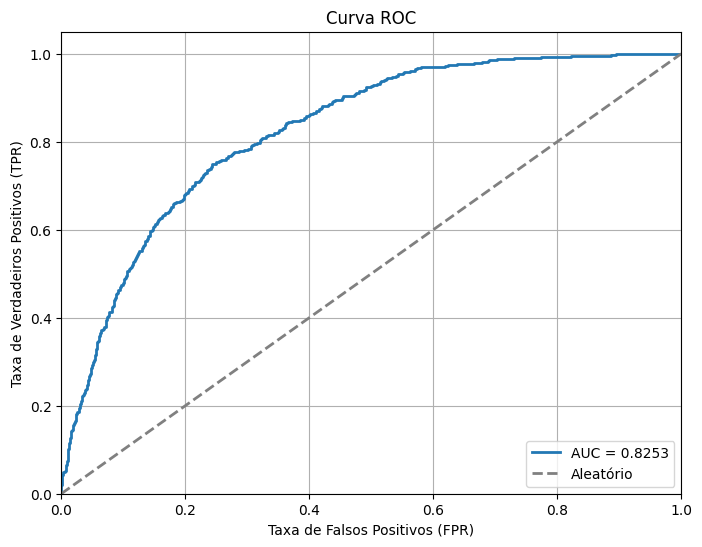

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 78.91%
Test F1-Score (Macro): 71.17%
Test KS Statistic: 50.5962% (p-value: 3.82e-107)

--- Evaluation Complete (Fold Three) ---
Final cleanup complete for Fold Three.


In [76]:
print("\n--- STab Final Evaluation on Test Set (Fold Three) ---")
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np_final = y_test_tensor_cpu.numpy()
predict_batch_size = 128

try:
    test_logits = model_final.predict([X_test_tensor], batch_size=predict_batch_size) 
    if test_logits is None or not isinstance(test_logits, np.ndarray):
         raise ValueError("Invalid model prediction during final evaluation.")
    else:
        probabilities_test = scipy_softmax(test_logits, axis=1)
        y_pred_test = np.argmax(probabilities_test, axis=1)
        y_pred_test_cpu = y_pred_test

        try:
            if is_binary_final:
                y_probs_positive_class = probabilities_test[:, 1]
                fpr, tpr, _ = roc_curve(y_test_cpu_np_final, y_probs_positive_class)
                roc_auc_test = auc(fpr, tpr)
                print(f"Test ROC AUC: {roc_auc_test:.4f}")

                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
                plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('Taxa de Falsos Positivos (FPR)')
                plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
                plt.title('Curva ROC') 
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.show()
            else:
                print("ROC AUC plot skipped: Not a binary classification problem.")
                roc_auc_test = np.nan
        except Exception as e:
            print(f"Error during ROC calculation/plotting: {e}")
            roc_auc_test = np.nan

        if is_binary_final:
            y_probs_test = y_probs_positive_class
            print("Probabilities for the positive class (1) extracted for KS.")
        else:
            y_probs_test = None
            print("KS statistic calculation skipped (not binary classification).")

except Exception as e:
    print(f"Error during final prediction: {e}")
    acc_test = 0.0
    f1_test = 0.0
    ks_statistic_test = np.nan
    roc_auc_test = np.nan

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np_final, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np_final, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np_final)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np_final == 0]
                class1_probs = y_probs_test[y_test_cpu_np_final == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")

print("\n--- Evaluation Complete (Fold Three) ---")

try:
    if 'stab_original_model_final' in locals(): del stab_original_model_final
    if 'stab_wrapped_model_final' in locals(): del stab_wrapped_model_final
    if 'model_final' in locals(): del model_final
    if 'optimizer_final' in locals(): del optimizer_final
    if 'history_final' in locals(): del history_final
    del X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor_cpu
    if 'train_dataset_for_fit' in locals(): del train_dataset_for_fit
    if 'val_dataset_for_fit' in locals(): del val_dataset_for_fit
    if 'test_logits' in locals(): del test_logits
    if 'probabilities_test' in locals(): del probabilities_test
    if 'y_probs_test' in locals(): del y_probs_test
    if 'y_pred_test_cpu' in locals(): del y_pred_test_cpu
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Final cleanup complete for Fold Three.")
except Exception as e:
    print(f"Error during final cleanup for Fold Three: {e}")

## KAN *Transformer*

### Parâmetros que serão variados

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import optuna
import gc
import os
import warnings
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ks_2samp
from scipy.special import softmax as scipy_softmax
from tabkanet.models import TabMLPNet

In [78]:
# Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]

# Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
X_val_fold_two = dfValFoldTwo.drop("Churn", axis=1)
y_val_fold_two = dfValFoldTwo["Churn"]

# Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]
X_val_fold_three = dfValFoldThree.drop("Churn", axis=1)
y_val_fold_three = dfValFoldThree["Churn"]

def get_quantile_bins(x_cont_pd, n_bins=4):
    print(f"Calculating bins for {x_cont_pd.shape[1]} features...")
    feature_dim = x_cont_pd.shape[1]
    bins = torch.zeros(feature_dim, n_bins + 1)
    for i in range(feature_dim):
        col_data = x_cont_pd.iloc[:, i].dropna().values
        if len(col_data) == 0:
             print(f"Warning: Column {i} ({x_cont_pd.columns[i]}) empty. Using default bins.")
             bins[i] = torch.linspace(0, 1, n_bins + 1)
             continue
        try:
            col_tensor = torch.tensor(col_data, dtype=torch.float32)
            if len(torch.unique(col_tensor)) < 2:
                 val = col_tensor[0].item() if len(col_tensor) > 0 else 0
                 print(f"Warning: Column {i} ({x_cont_pd.columns[i]}) has <= 1 unique value. Using default.")
                 bins[i] = torch.linspace(val - 1e-6, val + 1e-6, n_bins + 1)
            elif len(torch.unique(col_tensor)) < n_bins + 1:
                 print(f"Warning: Column {i} ({x_cont_pd.columns[i]}) fewer unique values than n_bins+1.")
                 unique_vals_sorted = torch.unique(col_tensor).sort()[0]
                 min_val, max_val = unique_vals_sorted[0], unique_vals_sorted[-1]
                 bins[i] = torch.linspace(min_val, max_val, n_bins + 1)
            else:
                 quantiles = torch.quantile(col_tensor, torch.linspace(0, 1, n_bins + 1))
                 for j in range(n_bins):
                     if quantiles[j+1] <= quantiles[j]: quantiles[j+1] = quantiles[j] + 1e-6
                 bins[i] = quantiles
        except Exception as e:
             print(f"Error calculating quantiles for column {i}: {e}. Using default.")
             bins[i] = torch.linspace(0, 1, n_bins + 1)
    return bins

n_bins_for_kan = 4
bins_tensor = get_quantile_bins(X_train_fold_one, n_bins=n_bins_for_kan)
print(f"Bins calculated with shape: {bins_tensor.shape}")

Calculating bins for 39 features...
Bins calculated with shape: torch.Size([39, 5])


### Otimização com Optuna

In [80]:
def objective_KANTransformer_Pytorch_KS(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    embedding_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64])
    mlp_layers = trial.suggest_int("mlp_layers", 1, 2)
    mlp_neurons = trial.suggest_categorical("mlp_neurons", [32, 64])
    mlp_hidden_dims = [mlp_neurons] * mlp_layers
    activation = trial.suggest_categorical("activation", ["relu", "gelu"])
    ffn_dropout_rate = trial.suggest_float("ffn_dropout_rate", 0.0, 0.4)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    nhead = trial.suggest_categorical("nhead", [2, 4])
    if embedding_dim % nhead != 0:
        possible_heads = [h for h in [2, 4] if embedding_dim % h == 0]
        if not possible_heads: raise optuna.exceptions.TrialPruned("Invalid head/dim.")
        nhead = trial.suggest_categorical("adjusted_nhead", possible_heads)
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [64, 128])
    attn_dropout_rate = trial.suggest_float("attn_dropout_rate", 0.0, 0.4)
    learnable_noise = trial.suggest_categorical("learnable_noise", [True, False])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    X_train_np_obj = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
    y_train_np_obj = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
    X_test_np_obj = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
    y_test_np_obj = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one

    num_continuous_features = X_train_np_obj.shape[1]
    output_size = len(np.unique(y_train_np_obj))

    if output_size != 2: return 0.0

    model = None
    try:
        model = TabMLPNet(
            output_dim=output_size, vocabulary={}, num_continuous_features=num_continuous_features,
            embedding_dim=embedding_dim, mlp_hidden_dims=mlp_hidden_dims, activation=activation,
            ffn_dropout_rate=ffn_dropout_rate, nhead=nhead, num_layers=num_layers,
            dim_feedforward=dim_feedforward, attn_dropout_rate=attn_dropout_rate,
            learninable_noise=learnable_noise, bins=bins_tensor.to(device)
        ).to(device)
    except Exception as e:
        print(f"Error creating TabMLPNet model in trial {trial.number}: {e}")
        del model; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        return 0.0

    objective_batch_size = 32
    predict_batch_size = 64

    X_train_tensor_obj = torch.tensor(X_train_np_obj, dtype=torch.float32)
    y_train_tensor_obj = torch.tensor(y_train_np_obj, dtype=torch.long)
    X_test_tensor_obj = torch.tensor(X_test_np_obj, dtype=torch.float32)
    y_test_cpu_np_obj = y_test_np_obj

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor_obj, y_train_tensor_obj)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=objective_batch_size, shuffle=True)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor_obj)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=predict_batch_size, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    n_epochs = 20

    all_logits_np = None
    probabilities_test = None
    y_probs_test = None
    ks_stat = 0.0

    try:
        try:
            for epoch in range(n_epochs):
                model.train()
                for batch_x, batch_y in train_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(categorical_x=None, continuous_x=batch_x)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
        except torch.cuda.OutOfMemoryError:
             print(f"OOM during training in trial {trial.number}. Pruning.")
             raise optuna.exceptions.TrialPruned("OOM during training")
        except Exception as e:
            print(f"Error during training in trial {trial.number}: {e}")
            raise e

        try:
            model.eval()
            all_logits = []
            with torch.no_grad():
                for batch_x_test in test_loader: # Renamed inner loop var
                    batch_x_test = batch_x_test[0].to(device)
                    logits_batch = model(categorical_x=None, continuous_x=batch_x_test)
                    all_logits.append(logits_batch.cpu().numpy())

            if not all_logits: raise ValueError("Prediction loop yielded no results.")
            all_logits_np = np.concatenate(all_logits, axis=0)

            probabilities_test = scipy_softmax(all_logits_np, axis=1)
            y_probs_test = probabilities_test[:, 1]

            if len(np.unique(y_test_cpu_np_obj)) == 2:
                try:
                    class0_probs = y_probs_test[y_test_cpu_np_obj == 0]
                    class1_probs = y_probs_test[y_test_cpu_np_obj == 1]
                    if len(class0_probs) > 0 and len(class1_probs) > 0:
                         ks_statistic_val, _ = ks_2samp(class1_probs, class0_probs)
                         ks_stat = ks_statistic_val
                except ValueError as e: print(f"Error calculating KS in trial {trial.number}: {e}; ks_stat=0"); ks_stat = 0.0
            else: pass
        except torch.cuda.OutOfMemoryError:
            print(f"OOM during evaluation in trial {trial.number}. Returning 0.")
            ks_stat = 0.0
        except Exception as e:
            print(f"Error during evaluation in trial {trial.number}: {e}. Returning 0.")
            ks_stat = 0.0

    finally:
        del model, optimizer, criterion
        del X_train_tensor_obj, y_train_tensor_obj, X_test_tensor_obj
        del train_dataset, train_loader, test_dataset, test_loader
        if 'all_logits_np' in locals() and all_logits_np is not None: del all_logits_np
        if 'probabilities_test' in locals() and probabilities_test is not None: del probabilities_test
        if 'y_probs_test' in locals() and y_probs_test is not None: del y_probs_test
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    trial.report(ks_stat, step=n_epochs)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return ks_stat

study_KANTransformer = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study_KANTransformer.optimize(objective_KANTransformer_Pytorch_KS, n_trials=5, timeout=1800) 

[I 2025-04-14 11:12:11,320] A new study created in memory with name: no-name-1708263b-7437-4ee2-a185-e57debd007c7
/home/live/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2025-04-14 11:13:43,190] Trial 0 finished with value: 0.5570289265505559 and parameters: {'embedding_dim': 64, 'mlp_layers': 2, 'mlp_neurons': 64, 'activation': 'gelu', 'ffn_dropout_rate': 0.2696655793310396, 'num_layers': 2, 'nhead': 4, 'dim_feedforward': 128, 'attn_dropout_rate': 0.32856958546608034, 'learnable_noise': False, 'learning_rate': 2.2535834318116974e-05, 'weight_decay': 1.0905147302877318e-05}. Best is trial 0 with value: 0.5570289265505559.
[I 2025-04-14 11:15:21,240] Trial 1 finished with value: 0.547064366516357 and parameters: {'em

### Treinamento do modelo

#### Fold One

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import keras4torch
import optuna
import pandas as pd
import numpy as np
import gc
import os
import warnings
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ks_2samp
from scipy.special import softmax as scipy_softmax
from tabkanet.models import TabMLPNet
from keras4torch.callbacks import ModelCheckpoint, LRScheduler, EarlyStopping


best_params_KANT = None
try:
    if 'study_KANTransformer' in locals() and study_KANTransformer.best_trial:
        best_trial = study_KANTransformer.best_trial
        print(f"Best trial number: {best_trial.number}")
        print(f"Best KS Score on Test Set during Optuna: {best_trial.value:.4f}")
        print("Best hyperparameters (KAN-Transformer):", best_trial.params)
        best_params_KANT = best_trial.params
        if 'adjusted_nhead' in best_params_KANT:
            best_params_KANT['nhead'] = best_params_KANT.pop('adjusted_nhead')
    else:
        raise ValueError("Optuna study 'study_KANTransformer' not found or has no best trial.")
except (optuna.exceptions.OptunaError, ValueError, AttributeError, NameError) as e: 
    print(f"Optuna study 'study_KANTransformer' retrieval failed: {e}. Using default parameters.")
    best_params_KANT = {
        "embedding_dim": 32, "mlp_layers": 1, "mlp_neurons": 32, "activation": "relu",
        "ffn_dropout_rate": 0.1, "num_layers": 1, "nhead": 2, "dim_feedforward": 64,
        "attn_dropout_rate": 0.1, "learnable_noise": True, "learning_rate": 0.0005, "weight_decay": 1e-5
    }
    print("Using default parameters:", best_params_KANT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if 'X_train_fold_one' not in locals() or 'y_train_fold_one' not in locals() or \
   'X_val_fold_one' not in locals() or 'y_val_fold_one' not in locals() or \
   'X_test_fold_one' not in locals() or 'y_test_fold_one' not in locals():
    raise NameError("One or more Fold One dataframes are not defined. Please run the splitting and preprocessing cells first.")


X_train_np_final = X_train_fold_one.values if isinstance(X_train_fold_one, pd.DataFrame) else X_train_fold_one
y_train_np_final = y_train_fold_one.values if isinstance(y_train_fold_one, pd.Series) else y_train_fold_one
X_test_np_final = X_test_fold_one.values if isinstance(X_test_fold_one, pd.DataFrame) else X_test_fold_one
y_test_np_final = y_test_fold_one.values if isinstance(y_test_fold_one, pd.Series) else y_test_fold_one
X_val_np_final = X_val_fold_one.values if isinstance(X_val_fold_one, pd.DataFrame) else X_val_fold_one
y_val_np_final = y_val_fold_one.values if isinstance(y_val_fold_one, pd.Series) else y_val_fold_one

X_train_np_final = X_train_np_final.astype(np.float32)
X_val_np_final = X_val_np_final.astype(np.float32)
X_test_np_final = X_test_np_final.astype(np.float32)
y_train_np_final = y_train_np_final.astype(np.int64)
y_val_np_final = y_val_np_final.astype(np.int64)
y_test_np_final = y_test_np_final.astype(np.int64)

X_train_t_final = torch.tensor(X_train_np_final)
y_train_t_final = torch.tensor(y_train_np_final)
X_val_t_final = torch.tensor(X_val_np_final)
y_val_t_final = torch.tensor(y_val_np_final)
X_test_t_final = torch.tensor(X_test_np_final) 
y_test_t_cpu_final = torch.tensor(y_test_np_final).cpu() 

train_dataset_final = torch.utils.data.TensorDataset(X_train_t_final, y_train_t_final)
val_dataset_final = torch.utils.data.TensorDataset(X_val_t_final, y_val_t_final)
test_dataset_final = torch.utils.data.TensorDataset(X_test_t_final) 

final_batch_size = 64 

train_loader_final = torch.utils.data.DataLoader(train_dataset_final, batch_size=final_batch_size, shuffle=True)
val_loader_final = torch.utils.data.DataLoader(val_dataset_final, batch_size=final_batch_size*2, shuffle=False)
test_loader_final = torch.utils.data.DataLoader(test_dataset_final, batch_size=final_batch_size*2, shuffle=False)

embedding_dim = best_params_KANT["embedding_dim"]
mlp_layers = best_params_KANT["mlp_layers"]
mlp_neurons = best_params_KANT["mlp_neurons"]
mlp_hidden_dims = [mlp_neurons] * mlp_layers
activation = best_params_KANT["activation"]
ffn_dropout_rate = best_params_KANT["ffn_dropout_rate"]
num_layers = best_params_KANT["num_layers"]
nhead = best_params_KANT.get("nhead", best_params_KANT.get("adjusted_nhead", 2))
dim_feedforward = best_params_KANT["dim_feedforward"]
attn_dropout_rate = best_params_KANT["attn_dropout_rate"]
learnable_noise = best_params_KANT["learnable_noise"]
learning_rate = best_params_KANT["learning_rate"]
weight_decay = best_params_KANT.get("weight_decay", 1e-5) 

input_size = X_train_np_final.shape[1]
output_size = len(np.unique(y_train_np_final))
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, EmbDim={embedding_dim}, MLPLayers={mlp_layers}x{mlp_neurons}, TFLayers={num_layers}, Heads={nhead}, LR={learning_rate:.6f}")

is_binary_final = (output_size == 2)
if not is_binary_final: print("Warning: Final eval - KS/ROC requires binary.")

if embedding_dim % nhead != 0:
    print(f"Error: Final 'embedding_dim' ({embedding_dim}) not divisible by 'nhead' ({nhead}). Adjusting.")
    possible_heads = [h for h in [2, 4, 8] if embedding_dim % h == 0] 
    nhead = possible_heads[0] if possible_heads else (2 if embedding_dim % 2 == 0 else 1)
    print(f"Fallback: Adjusted heads to {nhead}")

if 'bins_tensor' not in locals():
    raise NameError("bins_tensor is not defined. Please run the cell that calculates bins.")

model_final = TabMLPNet(
    output_dim=output_size, vocabulary={}, num_continuous_features=input_size,
    embedding_dim=embedding_dim, mlp_hidden_dims=mlp_hidden_dims, activation=activation,
    ffn_dropout_rate=ffn_dropout_rate, nhead=nhead, num_layers=num_layers,
    dim_feedforward=dim_feedforward, attn_dropout_rate=attn_dropout_rate,
    learninable_noise=learnable_noise, bins=bins_tensor.to(device) 
).to(device)

optimizer_final = torch.optim.AdamW(model_final.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion_final = nn.CrossEntropyLoss()

n_epochs_final = 5
patience_final = 15
best_val_acc = 0.0
epochs_no_improve = 0
best_model_state_dict = None

print(f"\n--- Starting Final Training ({n_epochs_final} epochs, batch size {final_batch_size}) ---")
for epoch in range(n_epochs_final):
    model_final.train()
    train_loss_epoch = 0.0
    for batch_x, batch_y in train_loader_final:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer_final.zero_grad()
        outputs = model_final(categorical_x=None, continuous_x=batch_x)
        loss = criterion_final(outputs, batch_y)
        loss.backward()
        optimizer_final.step()
        train_loss_epoch += loss.item()
    avg_train_loss = train_loss_epoch / len(train_loader_final)

    model_final.eval()
    val_loss_epoch = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for batch_x_val, batch_y_val in val_loader_final:
            batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
            val_outputs = model_final(categorical_x=None, continuous_x=batch_x_val)
            val_loss = criterion_final(val_outputs, batch_y_val)
            val_loss_epoch += val_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_total += batch_y_val.size(0)
            val_corrects += (val_preds == batch_y_val).sum().item()

    avg_val_loss = val_loss_epoch / len(val_loader_final)
    current_val_acc = val_corrects / val_total

    if (epoch + 1) % 10 == 0 or epoch == n_epochs_final - 1:
        print(f"Epoch {epoch+1}/{n_epochs_final}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        best_model_state_dict = model_final.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience_final:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        if best_model_state_dict:
            model_final.load_state_dict(best_model_state_dict)
            print("Loaded best model state based on validation accuracy.")
        break

if best_model_state_dict and epochs_no_improve < patience_final:
    model_final.load_state_dict(best_model_state_dict)
    print("Training finished. Loaded best model state based on validation accuracy.")

Best trial number: 0
Best KS Score on Test Set during Optuna: 0.5570
Best hyperparameters (KAN-Transformer): {'embedding_dim': 64, 'mlp_layers': 2, 'mlp_neurons': 64, 'activation': 'gelu', 'ffn_dropout_rate': 0.2696655793310396, 'num_layers': 2, 'nhead': 4, 'dim_feedforward': 128, 'attn_dropout_rate': 0.32856958546608034, 'learnable_noise': False, 'learning_rate': 2.2535834318116974e-05, 'weight_decay': 1.0905147302877318e-05}
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, EmbDim=64, MLPLayers=2x64, TFLayers=2, Heads=4, LR=0.000023

--- Starting Final Training (5 epochs, batch size 64) ---


/home/live/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 5/5, Train Loss: 0.4655, Val Loss: 0.4571, Val Acc: 0.7806
Training finished. Loaded best model state based on validation accuracy.



--- KAN-Transformer Final Evaluation on Test Set (Fold One) ---
Test ROC AUC: 0.8321


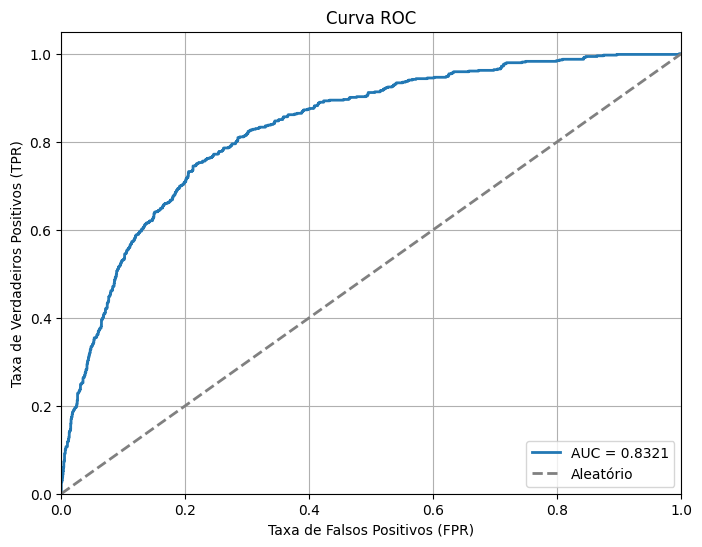

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 79.77%
Test F1-Score (Macro): 71.64%
Test KS Statistic: 53.2389% (p-value: 3.21e-121)

--- Evaluation Complete (Fold One) ---
Final cleanup complete for Fold One.


In [85]:
print("\n--- KAN-Transformer Final Evaluation on Test Set (Fold One) ---")
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np_final = y_test_np_final 

predict_batch_size = 128 

try:
    model_final.eval() 
    all_logits_test = []
    with torch.no_grad():
        for batch_x_test in test_loader_final: 
            batch_x_test = batch_x_test[0].to(device)
            logits_batch = model_final(categorical_x=None, continuous_x=batch_x_test)
            all_logits_test.append(logits_batch.cpu().numpy())

    if not all_logits_test:
        raise ValueError("Final prediction loop yielded no results.")

    test_logits = np.concatenate(all_logits_test, axis=0)
    probabilities_test = scipy_softmax(test_logits, axis=1) 
    y_pred_test = np.argmax(probabilities_test, axis=1)
    y_pred_test_cpu = y_pred_test

    try:
        if is_binary_final:
            y_probs_positive_class = probabilities_test[:, 1]
            fpr, tpr, _ = roc_curve(y_test_cpu_np_final, y_probs_positive_class)
            roc_auc_test = auc(fpr, tpr)
            print(f"Test ROC AUC: {roc_auc_test:.4f}")

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
            plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Taxa de Falsos Positivos (FPR)')
            plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
            plt.title('Curva ROC') 
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()
        else:
            print("ROC AUC plot skipped: Not a binary classification problem.")
            roc_auc_test = np.nan
    except Exception as e:
        print(f"Error during ROC calculation/plotting: {e}")
        roc_auc_test = np.nan

    if is_binary_final:
        y_probs_test = y_probs_positive_class
        print("Probabilities for the positive class (1) extracted for KS.")
    else:
        y_probs_test = None
        print("KS statistic calculation skipped (not binary classification).")

except Exception as e:
    print(f"Error during final prediction: {e}")
    acc_test = 0.0
    f1_test = 0.0
    ks_statistic_test = np.nan
    roc_auc_test = np.nan

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np_final, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np_final, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np_final)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np_final == 0]
                class1_probs = y_probs_test[y_test_cpu_np_final == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")


print("\n--- Evaluation Complete (Fold One) ---")

try:
    if 'model_final' in locals(): del model_final
    if 'optimizer_final' in locals(): del optimizer_final
    if 'criterion_final' in locals(): del criterion_final
    if 'history_final' in locals(): del history_final
    del X_train_t_final, y_train_t_final, X_val_t_final, y_val_t_final, X_test_t_final, y_test_t_cpu_final
    if 'train_dataset_final' in locals(): del train_dataset_final
    if 'val_dataset_final' in locals(): del val_dataset_final
    if 'test_dataset_final' in locals(): del test_dataset_final
    if 'train_loader_final' in locals(): del train_loader_final
    if 'val_loader_final' in locals(): del val_loader_final
    if 'test_loader_final' in locals(): del test_loader_final
    if 'test_logits' in locals(): del test_logits
    if 'probabilities_test' in locals(): del probabilities_test
    if 'y_probs_test' in locals(): del y_probs_test
    if 'y_pred_test_cpu' in locals(): del y_pred_test_cpu
    if 'best_model_state_dict' in locals(): del best_model_state_dict
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Final cleanup complete for Fold One.")
except Exception as e:
    print(f"Error during final cleanup for Fold One: {e}")

#### Fold Two

In [86]:
print("\n--- KAN-Transformer Final Training & Evaluation using Best Hyperparameters (Fold Two) ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if 'X_train_fold_two' not in locals() or 'y_train_fold_two' not in locals() or \
   'X_val_fold_two' not in locals() or 'y_val_fold_two' not in locals() or \
   'X_test_fold_two' not in locals() or 'y_test_fold_two' not in locals():
    raise NameError("One or more Fold Two dataframes are not defined. Please run the splitting and preprocessing cells first.")

X_train_np_final = X_train_fold_two.values if isinstance(X_train_fold_two, pd.DataFrame) else X_train_fold_two
y_train_np_final = y_train_fold_two.values if isinstance(y_train_fold_two, pd.Series) else y_train_fold_two
X_test_np_final = X_test_fold_two.values if isinstance(X_test_fold_two, pd.DataFrame) else X_test_fold_two
y_test_np_final = y_test_fold_two.values if isinstance(y_test_fold_two, pd.Series) else y_test_fold_two
X_val_np_final = X_val_fold_two.values if isinstance(X_val_fold_two, pd.DataFrame) else X_val_fold_two
y_val_np_final = y_val_fold_two.values if isinstance(y_val_fold_two, pd.Series) else y_val_fold_two

X_train_np_final = X_train_np_final.astype(np.float32)
X_val_np_final = X_val_np_final.astype(np.float32)
X_test_np_final = X_test_np_final.astype(np.float32)
y_train_np_final = y_train_np_final.astype(np.int64)
y_val_np_final = y_val_np_final.astype(np.int64)
y_test_np_final = y_test_np_final.astype(np.int64)

X_train_t_final = torch.tensor(X_train_np_final)
y_train_t_final = torch.tensor(y_train_np_final)
X_val_t_final = torch.tensor(X_val_np_final)
y_val_t_final = torch.tensor(y_val_np_final)
X_test_t_final = torch.tensor(X_test_np_final)
y_test_t_cpu_final = torch.tensor(y_test_np_final).cpu() 

train_dataset_final = torch.utils.data.TensorDataset(X_train_t_final, y_train_t_final)
val_dataset_final = torch.utils.data.TensorDataset(X_val_t_final, y_val_t_final)
test_dataset_final = torch.utils.data.TensorDataset(X_test_t_final)

final_batch_size = 64 

train_loader_final = torch.utils.data.DataLoader(train_dataset_final, batch_size=final_batch_size, shuffle=True)
val_loader_final = torch.utils.data.DataLoader(val_dataset_final, batch_size=final_batch_size*2, shuffle=False)
test_loader_final = torch.utils.data.DataLoader(test_dataset_final, batch_size=final_batch_size*2, shuffle=False)

if 'study_KANTransformer' not in locals() or not hasattr(study_KANTransformer, 'best_params') or not study_KANTransformer.best_trial:
    print("Warning: Optuna study 'study_KANTransformer' not found or no best trial. Using default parameters.")
    best_params_KANT = {
        "embedding_dim": 32, "mlp_layers": 1, "mlp_neurons": 32, "activation": "relu",
        "ffn_dropout_rate": 0.1, "num_layers": 1, "nhead": 2, "dim_feedforward": 64,
        "attn_dropout_rate": 0.1, "learnable_noise": True, "learning_rate": 0.0005, "weight_decay": 1e-5
    }
else:
    best_params_KANT = study_KANTransformer.best_params

embedding_dim = best_params_KANT["embedding_dim"]
mlp_layers = best_params_KANT["mlp_layers"]
mlp_neurons = best_params_KANT["mlp_neurons"]
mlp_hidden_dims = [mlp_neurons] * mlp_layers
activation = best_params_KANT["activation"]
ffn_dropout_rate = best_params_KANT["ffn_dropout_rate"]
num_layers = best_params_KANT["num_layers"]
nhead = best_params_KANT.get("nhead", best_params_KANT.get("adjusted_nhead", 2))
dim_feedforward = best_params_KANT["dim_feedforward"]
attn_dropout_rate = best_params_KANT["attn_dropout_rate"]
learnable_noise = best_params_KANT["learnable_noise"]
learning_rate = best_params_KANT["learning_rate"]
weight_decay = best_params_KANT.get("weight_decay", 1e-5)

input_size = X_train_np_final.shape[1]
output_size = len(np.unique(y_train_np_final))
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, EmbDim={embedding_dim}, MLPLayers={mlp_layers}x{mlp_neurons}, TFLayers={num_layers}, Heads={nhead}, LR={learning_rate:.6f}")

is_binary_final = (output_size == 2)
if not is_binary_final: print("Warning: Final eval - KS/ROC requires binary.")

if embedding_dim % nhead != 0:
    print(f"Error: Final 'embedding_dim' ({embedding_dim}) not divisible by 'nhead' ({nhead}). Adjusting.")
    possible_heads = [h for h in [2, 4, 8] if embedding_dim % h == 0]
    nhead = possible_heads[0] if possible_heads else (2 if embedding_dim % 2 == 0 else 1)
    print(f"Fallback: Adjusted heads to {nhead}")

model_final = TabMLPNet(
    output_dim=output_size, vocabulary={}, num_continuous_features=input_size,
    embedding_dim=embedding_dim, mlp_hidden_dims=mlp_hidden_dims, activation=activation,
    ffn_dropout_rate=ffn_dropout_rate, nhead=nhead, num_layers=num_layers,
    dim_feedforward=dim_feedforward, attn_dropout_rate=attn_dropout_rate,
    learninable_noise=learnable_noise, bins=bins_tensor.to(device)
).to(device)

optimizer_final = torch.optim.AdamW(model_final.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion_final = nn.CrossEntropyLoss()

n_epochs_final = 5
patience_final = 15
best_val_acc = 0.0
epochs_no_improve = 0
best_model_state_dict = None

print(f"\n--- Starting Final Training ({n_epochs_final} epochs, batch size {final_batch_size}) ---")
for epoch in range(n_epochs_final):
    model_final.train()
    train_loss_epoch = 0.0
    for batch_x, batch_y in train_loader_final:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer_final.zero_grad()
        outputs = model_final(categorical_x=None, continuous_x=batch_x)
        loss = criterion_final(outputs, batch_y)
        loss.backward()
        optimizer_final.step()
        train_loss_epoch += loss.item()
    avg_train_loss = train_loss_epoch / len(train_loader_final)

    model_final.eval()
    val_loss_epoch = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for batch_x_val, batch_y_val in val_loader_final:
            batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
            val_outputs = model_final(categorical_x=None, continuous_x=batch_x_val)
            val_loss = criterion_final(val_outputs, batch_y_val)
            val_loss_epoch += val_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_total += batch_y_val.size(0)
            val_corrects += (val_preds == batch_y_val).sum().item()

    avg_val_loss = val_loss_epoch / len(val_loader_final)
    current_val_acc = val_corrects / val_total

    if (epoch + 1) % 10 == 0 or epoch == n_epochs_final - 1:
        print(f"Epoch {epoch+1}/{n_epochs_final}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        best_model_state_dict = model_final.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience_final:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        if best_model_state_dict:
            model_final.load_state_dict(best_model_state_dict)
            print("Loaded best model state based on validation accuracy.")
        break

if best_model_state_dict and epochs_no_improve < patience_final:
    model_final.load_state_dict(best_model_state_dict)
    print("Training finished. Loaded best model state based on validation accuracy.")

print("--- Final Training Finished ---")
print("-" * 40 + "\n")


--- KAN-Transformer Final Training & Evaluation using Best Hyperparameters (Fold Two) ---
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, EmbDim=64, MLPLayers=2x64, TFLayers=2, Heads=4, LR=0.000023

--- Starting Final Training (5 epochs, batch size 64) ---


/home/live/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 5/5, Train Loss: 0.4585, Val Loss: 0.4527, Val Acc: 0.7827
Training finished. Loaded best model state based on validation accuracy.
--- Final Training Finished ---
----------------------------------------




--- Final KAN-Transformer Evaluation on Test Set (Fold Two) ---
Test ROC AUC: 0.8279


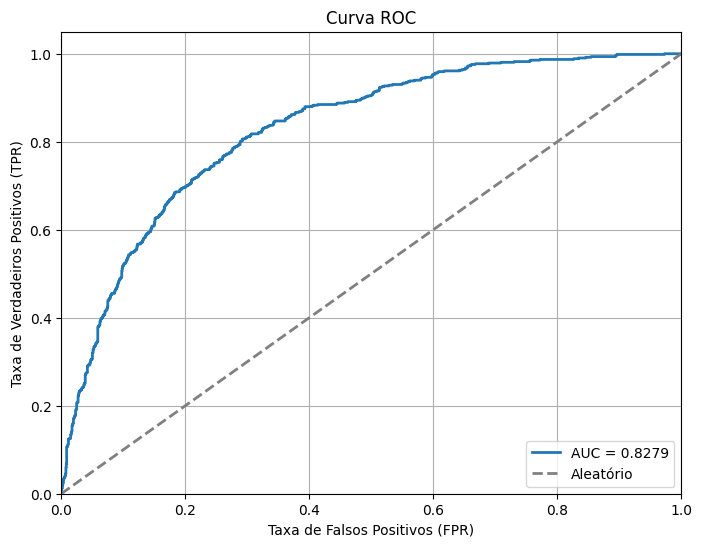

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 79.94%
Test F1-Score (Macro): 72.30%
Test KS Statistic: 51.3948% (p-value: 2.76e-110)

--- Evaluation Complete (Fold Two) ---
Final cleanup complete for Fold Two.


In [87]:
print("\n--- Final KAN-Transformer Evaluation on Test Set (Fold Two) ---")
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np_final = y_test_t_cpu_final.numpy() 

predict_batch_size = 128

try:
    model_final.eval() 
    all_logits_test = []
    with torch.no_grad():
        for batch_x_test in test_loader_final: 
            batch_x_test = batch_x_test[0].to(device)
            logits_batch = model_final(categorical_x=None, continuous_x=batch_x_test)
            all_logits_test.append(logits_batch.cpu().numpy())

    if not all_logits_test:
        raise ValueError("Final prediction loop yielded no results.")

    test_logits = np.concatenate(all_logits_test, axis=0)
    probabilities_test = scipy_softmax(test_logits, axis=1) 
    y_pred_test = np.argmax(probabilities_test, axis=1)
    y_pred_test_cpu = y_pred_test

    try:
        if is_binary_final:
            y_probs_positive_class = probabilities_test[:, 1]
            fpr, tpr, _ = roc_curve(y_test_cpu_np_final, y_probs_positive_class)
            roc_auc_test = auc(fpr, tpr)
            print(f"Test ROC AUC: {roc_auc_test:.4f}")

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
            plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Taxa de Falsos Positivos (FPR)')
            plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
            plt.title('Curva ROC') 
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()
        else:
            print("ROC AUC plot skipped: Not a binary classification problem.")
            roc_auc_test = np.nan
    except Exception as e:
        print(f"Error during ROC calculation/plotting: {e}")
        roc_auc_test = np.nan
        
    if is_binary_final:
        y_probs_test = y_probs_positive_class
        print("Probabilities for the positive class (1) extracted for KS.")
    else:
        y_probs_test = None
        print("KS statistic calculation skipped (not binary classification).")

except Exception as e:
    print(f"Error during final prediction: {e}")
    acc_test = 0.0
    f1_test = 0.0
    ks_statistic_test = np.nan
    roc_auc_test = np.nan

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np_final, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np_final, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np_final)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np_final == 0]
                class1_probs = y_probs_test[y_test_cpu_np_final == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")


print("\n--- Evaluation Complete (Fold Two) ---")

try:
    if 'model_final' in locals(): del model_final
    if 'optimizer_final' in locals(): del optimizer_final
    if 'criterion_final' in locals(): del criterion_final
    if 'history_final' in locals(): del history_final
    if 'X_train_t_final' in locals(): del X_train_t_final
    if 'y_train_t_final' in locals(): del y_train_t_final
    if 'X_val_t_final' in locals(): del X_val_t_final
    if 'y_val_t_final' in locals(): del y_val_t_final
    if 'X_test_t_final' in locals(): del X_test_t_final
    if 'y_test_t_cpu_final' in locals(): del y_test_t_cpu_final
    if 'train_dataset_final' in locals(): del train_dataset_final
    if 'val_dataset_final' in locals(): del val_dataset_final
    if 'test_dataset_final' in locals(): del test_dataset_final
    if 'train_loader_final' in locals(): del train_loader_final
    if 'val_loader_final' in locals(): del val_loader_final
    if 'test_loader_final' in locals(): del test_loader_final
    if 'test_logits' in locals(): del test_logits
    if 'probabilities_test' in locals(): del probabilities_test
    if 'y_probs_test' in locals(): del y_probs_test
    if 'y_pred_test_cpu' in locals(): del y_pred_test_cpu
    if 'best_model_state_dict' in locals(): del best_model_state_dict
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Final cleanup complete for Fold Two.")
except Exception as e:
    print(f"Error during final cleanup for Fold Two: {e}")

#### Fold Three

In [88]:
print("\n--- KAN-Transformer Final Training & Evaluation using Best Hyperparameters (Fold Three) ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if 'X_train_fold_three' not in locals() or 'y_train_fold_three' not in locals() or \
   'X_val_fold_three' not in locals() or 'y_val_fold_three' not in locals() or \
   'X_test_fold_three' not in locals() or 'y_test_fold_three' not in locals():
    raise NameError("One or more Fold Three dataframes are not defined. Please run the splitting and preprocessing cells first.")


X_train_np_final = X_train_fold_three.values if isinstance(X_train_fold_three, pd.DataFrame) else X_train_fold_three
y_train_np_final = y_train_fold_three.values if isinstance(y_train_fold_three, pd.Series) else y_train_fold_three
X_test_np_final = X_test_fold_three.values if isinstance(X_test_fold_three, pd.DataFrame) else X_test_fold_three
y_test_np_final = y_test_fold_three.values if isinstance(y_test_fold_three, pd.Series) else y_test_fold_three
X_val_np_final = X_val_fold_three.values if isinstance(X_val_fold_three, pd.DataFrame) else X_val_fold_three
y_val_np_final = y_val_fold_three.values if isinstance(y_val_fold_three, pd.Series) else y_val_fold_three

X_train_np_final = X_train_np_final.astype(np.float32)
X_val_np_final = X_val_np_final.astype(np.float32)
X_test_np_final = X_test_np_final.astype(np.float32)
y_train_np_final = y_train_np_final.astype(np.int64)
y_val_np_final = y_val_np_final.astype(np.int64)
y_test_np_final = y_test_np_final.astype(np.int64)

X_train_t_final = torch.tensor(X_train_np_final)
y_train_t_final = torch.tensor(y_train_np_final)
X_val_t_final = torch.tensor(X_val_np_final)
y_val_t_final = torch.tensor(y_val_np_final)
X_test_t_final = torch.tensor(X_test_np_final) 
y_test_t_cpu_final = torch.tensor(y_test_np_final).cpu()

train_dataset_final = torch.utils.data.TensorDataset(X_train_t_final, y_train_t_final)
val_dataset_final = torch.utils.data.TensorDataset(X_val_t_final, y_val_t_final)
test_dataset_final = torch.utils.data.TensorDataset(X_test_t_final) 

final_batch_size = 64 

train_loader_final = torch.utils.data.DataLoader(train_dataset_final, batch_size=final_batch_size, shuffle=True)
val_loader_final = torch.utils.data.DataLoader(val_dataset_final, batch_size=final_batch_size*2, shuffle=False)
test_loader_final = torch.utils.data.DataLoader(test_dataset_final, batch_size=final_batch_size*2, shuffle=False)

if 'study_KANTransformer' not in locals() or not hasattr(study_KANTransformer, 'best_params') or not study_KANTransformer.best_trial:
    print("Warning: Optuna study 'study_KANTransformer' not found or no best trial. Using default parameters.")
    best_params_KANT = {
        "embedding_dim": 32, "mlp_layers": 1, "mlp_neurons": 32, "activation": "relu",
        "ffn_dropout_rate": 0.1, "num_layers": 1, "nhead": 2, "dim_feedforward": 64,
        "attn_dropout_rate": 0.1, "learnable_noise": True, "learning_rate": 0.0005, "weight_decay": 1e-5
    }
else:
    best_params_KANT = study_KANTransformer.best_params

embedding_dim = best_params_KANT["embedding_dim"]
mlp_layers = best_params_KANT["mlp_layers"]
mlp_neurons = best_params_KANT["mlp_neurons"]
mlp_hidden_dims = [mlp_neurons] * mlp_layers
activation = best_params_KANT["activation"]
ffn_dropout_rate = best_params_KANT["ffn_dropout_rate"]
num_layers = best_params_KANT["num_layers"]
nhead = best_params_KANT.get("nhead", best_params_KANT.get("adjusted_nhead", 2)) 
dim_feedforward = best_params_KANT["dim_feedforward"]
attn_dropout_rate = best_params_KANT["attn_dropout_rate"]
learnable_noise = best_params_KANT["learnable_noise"]
learning_rate = best_params_KANT["learning_rate"]
weight_decay = best_params_KANT.get("weight_decay", 1e-5)

input_size = X_train_np_final.shape[1]
output_size = len(np.unique(y_train_np_final))
print(f"Final Model Config: Input Size={input_size}, Output Size={output_size}, EmbDim={embedding_dim}, MLPLayers={mlp_layers}x{mlp_neurons}, TFLayers={num_layers}, Heads={nhead}, LR={learning_rate:.6f}")

is_binary_final = (output_size == 2)
if not is_binary_final: print("Warning: Final eval - KS/ROC requires binary.")

if embedding_dim % nhead != 0:
    print(f"Error: Final 'embedding_dim' ({embedding_dim}) not divisible by 'nhead' ({nhead}). Adjusting.")
    possible_heads = [h for h in [2, 4, 8] if embedding_dim % h == 0]
    nhead = possible_heads[0] if possible_heads else (2 if embedding_dim % 2 == 0 else 1)
    print(f"Fallback: Adjusted heads to {nhead}")

model_final = TabMLPNet(
    output_dim=output_size, vocabulary={}, num_continuous_features=input_size,
    embedding_dim=embedding_dim, mlp_hidden_dims=mlp_hidden_dims, activation=activation,
    ffn_dropout_rate=ffn_dropout_rate, nhead=nhead, num_layers=num_layers,
    dim_feedforward=dim_feedforward, attn_dropout_rate=attn_dropout_rate,
    learninable_noise=learnable_noise, bins=bins_tensor.to(device) 
).to(device)

optimizer_final = torch.optim.AdamW(model_final.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion_final = nn.CrossEntropyLoss()

n_epochs_final = 5
patience_final = 15
best_val_acc = 0.0
epochs_no_improve = 0
best_model_state_dict = None

print(f"\n--- Starting Final Training ({n_epochs_final} epochs, batch size {final_batch_size}) ---")
for epoch in range(n_epochs_final):
    model_final.train()
    train_loss_epoch = 0.0
    for batch_x, batch_y in train_loader_final:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer_final.zero_grad()
        outputs = model_final(categorical_x=None, continuous_x=batch_x)
        loss = criterion_final(outputs, batch_y)
        loss.backward()
        optimizer_final.step()
        train_loss_epoch += loss.item()
    avg_train_loss = train_loss_epoch / len(train_loader_final)

    model_final.eval()
    val_loss_epoch = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for batch_x_val, batch_y_val in val_loader_final:
            batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
            val_outputs = model_final(categorical_x=None, continuous_x=batch_x_val)
            val_loss = criterion_final(val_outputs, batch_y_val)
            val_loss_epoch += val_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_total += batch_y_val.size(0)
            val_corrects += (val_preds == batch_y_val).sum().item()

    avg_val_loss = val_loss_epoch / len(val_loader_final)
    current_val_acc = val_corrects / val_total

    if (epoch + 1) % 10 == 0 or epoch == n_epochs_final - 1:
        print(f"Epoch {epoch+1}/{n_epochs_final}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {current_val_acc:.4f}")

    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        epochs_no_improve = 0
        best_model_state_dict = model_final.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience_final:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        if best_model_state_dict:
            model_final.load_state_dict(best_model_state_dict)
            print("Loaded best model state based on validation accuracy.")
        break

if best_model_state_dict and epochs_no_improve < patience_final:
    model_final.load_state_dict(best_model_state_dict)
    print("Training finished. Loaded best model state based on validation accuracy.")

print("--- Final Training Finished ---")
print("-" * 40 + "\n")


--- KAN-Transformer Final Training & Evaluation using Best Hyperparameters (Fold Three) ---
Using device: cuda
Final Model Config: Input Size=39, Output Size=2, EmbDim=64, MLPLayers=2x64, TFLayers=2, Heads=4, LR=0.000023

--- Starting Final Training (5 epochs, batch size 64) ---


/home/live/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 5/5, Train Loss: 0.4644, Val Loss: 0.4805, Val Acc: 0.7670
Training finished. Loaded best model state based on validation accuracy.
--- Final Training Finished ---
----------------------------------------




--- Final KAN-Transformer Evaluation on Test Set (Fold Three) ---
Test ROC AUC: 0.8018


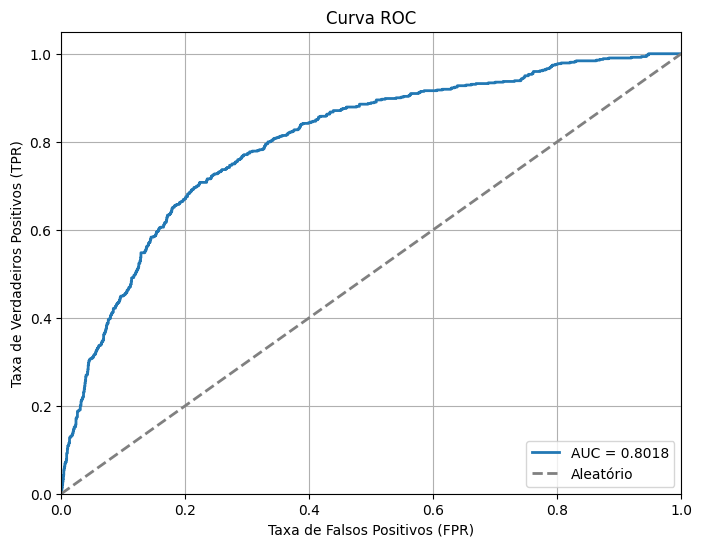

Probabilities for the positive class (1) extracted for KS.

Test Accuracy: 77.97%
Test F1-Score (Macro): 71.80%
Test KS Statistic: 48.4213% (p-value: 1.01e-97)

--- Evaluation Complete (Fold Three) ---
Final cleanup complete for Fold Three.


In [89]:
print("\n--- Final KAN-Transformer Evaluation on Test Set (Fold Three) ---")
y_probs_test = None
y_pred_test_cpu = None
y_test_cpu_np_final = y_test_t_cpu_final.numpy() 

predict_batch_size = 128

try:
    model_final.eval() 
    all_logits_test = []
    with torch.no_grad():
        for batch_x_test in test_loader_final: 
            batch_x_test = batch_x_test[0].to(device)
            logits_batch = model_final(categorical_x=None, continuous_x=batch_x_test)
            all_logits_test.append(logits_batch.cpu().numpy())

    if not all_logits_test: raise ValueError("Final prediction loop yielded no results.")

    test_logits = np.concatenate(all_logits_test, axis=0)
    probabilities_test = scipy_softmax(test_logits, axis=1)
    y_pred_test = np.argmax(probabilities_test, axis=1)
    y_pred_test_cpu = y_pred_test

    try:
        if is_binary_final:
            y_probs_positive_class = probabilities_test[:, 1]
            fpr, tpr, _ = roc_curve(y_test_cpu_np_final, y_probs_positive_class)
            roc_auc_test = auc(fpr, tpr)
            print(f"Test ROC AUC: {roc_auc_test:.4f}")

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='#2278b4', lw=2, label=f'AUC = {roc_auc_test:.4f}')
            plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Taxa de Falsos Positivos (FPR)')
            plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
            plt.title('Curva ROC')
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()
        else:
            print("ROC AUC plot skipped: Not a binary classification problem.")
            roc_auc_test = np.nan
    except Exception as e:
        print(f"Error during ROC calculation/plotting: {e}")
        roc_auc_test = np.nan

    if is_binary_final:
        y_probs_test = y_probs_positive_class
        print("Probabilities for the positive class (1) extracted for KS.")
    else:
        y_probs_test = None
        print("KS statistic calculation skipped (not binary classification).")

except Exception as e:
    print(f"Error during final prediction: {e}")
    acc_test = 0.0
    f1_test = 0.0
    ks_statistic_test = np.nan
    roc_auc_test = np.nan

if y_pred_test_cpu is not None:
    acc_test = accuracy_score(y_test_cpu_np_final, y_pred_test_cpu)
    f1_test = f1_score(y_test_cpu_np_final, y_pred_test_cpu, average="macro", zero_division=0)
    print(f"\nTest Accuracy: {acc_test * 100:.2f}%")
    print(f"Test F1-Score (Macro): {f1_test * 100:.2f}%")

    ks_statistic_test = np.nan
    if is_binary_final and y_probs_test is not None:
        if len(np.unique(y_test_cpu_np_final)) == 2:
            try:
                class0_probs = y_probs_test[y_test_cpu_np_final == 0]
                class1_probs = y_probs_test[y_test_cpu_np_final == 1]
                if len(class0_probs) > 0 and len(class1_probs) > 0:
                     ks_statistic_test, p_value = ks_2samp(class1_probs, class0_probs)
                     print(f"Test KS Statistic: {ks_statistic_test * 100:.4f}% (p-value: {p_value:.3g})")
                else: print("KS Statistic calculation skipped: One class missing.")
            except ValueError as e: print(f"Could not calculate KS statistic: {e}.")
        else: print("KS Statistic calculation skipped: Test set not binary.")
    else: pass
else: print("\nSkipping final metric calculation.")


print("\n--- Evaluation Complete (Fold Three) ---")

try:
    if 'model_final' in locals(): del model_final
    if 'optimizer_final' in locals(): del optimizer_final
    if 'criterion_final' in locals(): del criterion_final
    if 'history_final' in locals(): del history_final
    if 'X_train_t_final' in locals(): del X_train_t_final
    if 'y_train_t_final' in locals(): del y_train_t_final
    if 'X_val_t_final' in locals(): del X_val_t_final
    if 'y_val_t_final' in locals(): del y_val_t_final
    if 'X_test_t_final' in locals(): del X_test_t_final
    if 'y_test_t_cpu_final' in locals(): del y_test_t_cpu_final
    if 'train_dataset_final' in locals(): del train_dataset_final
    if 'val_dataset_final' in locals(): del val_dataset_final
    if 'test_dataset_final' in locals(): del test_dataset_final
    if 'train_loader_final' in locals(): del train_loader_final
    if 'val_loader_final' in locals(): del val_loader_final
    if 'test_loader_final' in locals(): del test_loader_final
    if 'test_logits' in locals(): del test_logits
    if 'probabilities_test' in locals(): del probabilities_test
    if 'y_probs_test' in locals(): del y_probs_test
    if 'y_pred_test_cpu' in locals(): del y_pred_test_cpu
    if 'best_model_state_dict' in locals(): del best_model_state_dict
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Final cleanup complete for Fold Three.")
except Exception as e:
    print(f"Error during final cleanup for Fold Three: {e}")